# Draft analysis 

---

Group name: mk350

---


## Introduction

<h4>Subject Introduction:</h4>
Eine Hauptuntersuchung (HU) muss bei allen Fahrzeugen alle 2 bzw. 3 Jahre stattfinden.
Somit stellt die HU eine häufig vorkommende Leistung in Werkstätten dar. In meinem Projekt möchte ich die Anzahl der
erwarteten HUs in den nächsten 30 Tagen für verschiedene Werkstätte hervorsagen. Die Werkstätten können dudurch besser
ihr Personal und Umsatz planen.

<h4>Motivation:</h4>
Mein Arbeitgebert (Gesellschaft für technische Überwachung (GTÜ)) entwickelt eine Software für unsere Partnerwerstätten.
Die Software soll den Werkstattbetrieb vereinfachen. Typische Funktionen sind das einscannen von Fahrzeugpapieren, das automatische Erstellen von Rechnungen oder eine Übersicht über die erbrachten Leistungen des Tages. Die Software soll stetig mit weiteren Features ausgebaut werden, um uns von Konkurennten abzuheben und so neue Werkstätten als Partner zu gewinnen. Mein HU-Forecast ist also ein gutes Feature, um unsere Software zu verbessern und uns von der Konkurrenz abzuheben.
Hilfreiche Quellen werden u.a. sein: Introduction to Machine Learning with Python (von Andreas Müller) und Machine Learning kompakt: Ein Einstieg für Studierende der Naturwissenschaften (essentials) (von Kenny Choo).

<h4>Research Question:</h4>
Wie viele HUs werden pro Tag pro Unterbüro (= Werkstatt) in den nächsten 30 Tagen erwartet?

<h4>Data Dictionary:</h4>

Die Variabeln der ursprünglichen Daten sind in der Tabelle abgebildet. Daraus berechen ich später weitere Variabeln (siehe Kapitel "Feature Engineering)

| Name  |   Description	| Role   	| Type   	|  Format 	|
|---	|---	        |---    	|---	    |---	|
|   HU	|   Anzahl der HUs, die an diesem Tag in dieser Werkstatt durchgeführt wurden	   |   	response    |   numeric	    |  int 	|
|   Unterbüro	|   	ID des Unterbüros        |   	ID    |   	nominal    |  string 	|
|   day	|   Tag des Monats |   	predictor    |   numeric	    |   int	|
| Bundeslanmd | Bundesland, in dem die Werkstatt liegt | ID | nominal  | string


In [19]:
# Anonymisierte Daten laden
from pathlib import Path

anonym_df = pl.read_csv(r"C:\Users\Krupinski\OneDrive - GTÜ mbH\Desktop\HU_Forecast\Data-Analytics\data\interim\anonym_df.csv")

# anonym_df = anonym_df.with_columns(
#     pl.col('DATUM').str.strptime(pl.Date, "%Y-%m-%d")
#)

## Setup

In [ ]:

from pathlib import Path
import polars as pl
import oracledb
import polars as pl
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np

# Einstellungen für eine bessere Darstellung der Dataframes im Notebook:
pl.Config.set_fmt_str_lengths(200)  # Maximale Länge der String-Werte (falls nötig)
pl.Config.set_tbl_rows(1000)         # Zeilenanzahl für die Anzeige erhöhen (Standard: 25)
pl.Config.set_tbl_cols(200)          # Maximale Anzahl der Spalten (optional)

polars.config.Config

## Data

## Import data

In [ ]:
# Die Originaldaten wurden wegen Datenschutz anonymisiert
# Aktuelles Arbeitsverzeichnis ermitteln
current_dir = Path.cwd()

# Relativer Pfad zur Datei
data_path = current_dir.parent / "data" / "interim" / "anonym_df.csv"

# Datei lesen
anonym_df = pl.read_csv(data_path)


### Data structure
Das Dataframe, welches mir zur Verfügung steht, hat folgende Spalten:
- Datum: Datum, an dem die HU durchgeführt wurde
- HU: Anzahl der HUs, die an diesem Tag in dieser Werkstatt/Unterbuero durchgeführt wurden
- Bundesland: Bundesland, in dem die Werkstatt/Unterbuero ist
- Unique Unterbüro Anonym: Anonymsierter Name der Werkstatt/Unterbüros

In [23]:
anonym_df.head()

DATUM,HU,BUNDESLAND,UNIQUE_UNTERBUERO_ANONYM
str,i64,str,str
"""2022-06-14""",21,"""Hessen""","""UB_1128"""
"""2021-04-29""",12,"""Baden-Württemberg""","""UB_294"""
"""2021-10-02""",9,"""Baden-Württemberg""","""UB_1115"""
"""2022-01-05""",32,"""Nordrhein-Westfalen""","""UB_297"""
"""2021-12-13""",7,"""Sachsen""","""UB_508"""


In [25]:
anonym_df.schema

Schema([('DATUM', String),
        ('HU', Int64),
        ('BUNDESLAND', String),
        ('UNIQUE_UNTERBUERO_ANONYM', String)])

### Data corrections

Das Datum liegt als String vor. Für die nächsten Schritte ist es besser, wenn es als Date-Format angegeben wird.

In [29]:
anonym_df = anonym_df.with_columns(pl.col("DATUM").str.strptime(pl.Date, "%Y-%m-%d"))

SchemaError: invalid series dtype: expected `String`, got `date`

Das Dataframe enthält nur Datenpunkte für Tage, an denen mindestens eine HU durchgeführt wurde. Für das Modelltraining ist es aber wichtig auch Datenpunkte zu haben, die Tage ohne durchgeführte HUs repräsentieren. Im folgenden wird das Dataframe so ergänzt, dass am Ende jedes Unterbüro für jeden Tag eine eigene Zeile besitzt.

In [30]:
# Erstelle eine Liste aller einzigartigen UNIQUE_UNTERBUERO_ANONYM
unique_unterbueros = anonym_df.select('UNIQUE_UNTERBUERO_ANONYM').unique()

min_date = anonym_df.select(pl.min('DATUM')).item()
max_date = anonym_df.select(pl.max('DATUM')).item()
    
# Generiere alle Daten zwischen min und max
all_dates = pl.date_range(
    start=min_date, 
    end=max_date, 
    interval='1d', 
    eager=True
)

# Kartesisches Produkt von Unterbueros und Daten
expanded_df = (
        unique_unterbueros.join(
            pl.DataFrame({'DATUM': all_dates}), 
            how='cross'
        )
        .with_columns([
            pl.lit(0).alias('HU')
        ])
    )

# Gruppiere den originalen DataFrame, um BUNDESLAND für jeden UNIQUE_UNTERBUERO_ANONYM zu bestimmen
bundesland_map = (
        anonym_df.group_by('UNIQUE_UNTERBUERO_ANONYM')
        .agg(pl.first('BUNDESLAND').alias('BUNDESLAND'))
    )

# Verbinde BUNDESLAND mit expanded_df
expanded_df = expanded_df.join(
        bundesland_map, 
        on='UNIQUE_UNTERBUERO_ANONYM', 
        how='left'
    )

# Spalten in richtige Reihenfolge machen
expanded_df = expanded_df.select("DATUM", "HU", "BUNDESLAND", "UNIQUE_UNTERBUERO_ANONYM").with_columns(pl.col("HU").cast(pl.Int64))

# Kombiniere den ursprünglichen und den erweiterten DataFrame
df_all_days = pl.concat([
        anonym_df, 
        expanded_df.join(anonym_df, on=['UNIQUE_UNTERBUERO_ANONYM', 'DATUM'], how='anti')
    ], rechunk=False)

Jetzt besitzt das Dataframe für jedes Unterbüro und für jeden Tag (vom frühsten bis zum spätesten Zeitpunkt der Datenaufzeichnung) eine eigene Zeile. 
Da aber manche Unterbüros nicht im gesamten Aufzeichnungszeitraum geöffnet haben, gibt es für manche Unterbüros Phasen langer Inaktivität. Diese Inaktiven Phasen würden das Modell verwirren (Da das Modell nur verwendet wird, um später die HUs aktiver Unterbüros vorherszugane, sollten unsere Datenpunkte auch nur aktive Zeiträume wiederspiegeln).
Daher identifiziere ich im folgenden die inaktiven Phasen und lösche alle Datenpunkte in dieser Phase:

Zur besseren Verständlichkeit werden 4 zufällige Unterbueros mit solch inaktiven Phasen visualisiert. Alle Datenpunkte im rot markierten Bereich werden anschließend gelöscht.


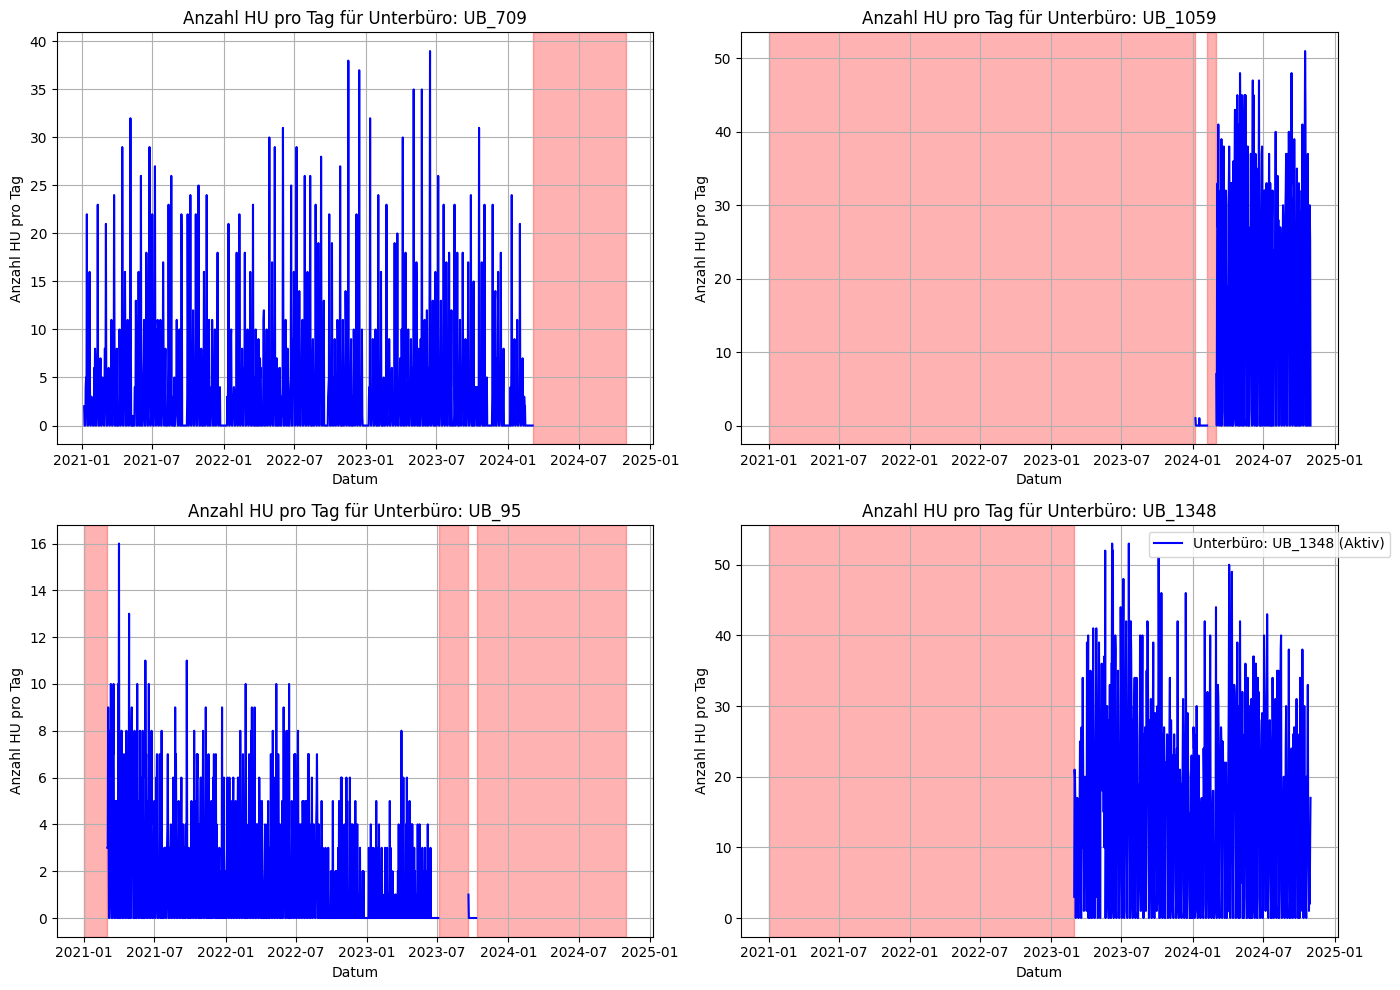

In [33]:
# Schritt 1: Lege eine Spalte INACTIVE an und markiere darin alle Zeilen, für die das Unterbüro seit 21 Tagen inaktiv ist
df_all_days = (
    df_all_days
    .sort(by=["UNIQUE_UNTERBUERO_ANONYM", "DATUM"])  # Sortiere die Daten
    .with_columns(
        pl.when(
            pl.col("HU").rolling_sum(window_size=21, min_periods=1).over("UNIQUE_UNTERBUERO_ANONYM") == 0
        ).then(True).otherwise(False).alias("INACTIVE")
    )
)

# Schritt 2: Zusammenhängende inaktive Zeiträume pro Unterbüro finden
def find_inactive_periods(df):
    df = df.with_columns(
        (
            (pl.col("INACTIVE") != pl.col("INACTIVE").shift(1)).cum_sum().alias("period_group")
        )
    )

    inactive_periods = (
        df.filter(pl.col("INACTIVE"))
        .group_by(["UNIQUE_UNTERBUERO_ANONYM", "period_group"])
        .agg([ 
            pl.col("DATUM").min().alias("start_date"),
            pl.col("DATUM").max().alias("end_date"),
            pl.count("DATUM").alias("duration"),
        ])
        .filter(pl.col("duration") > 21)
    )

    return inactive_periods

# Visualisierung:
inactive_periods = find_inactive_periods(df_all_days)

# 4 zufällige Unterbüros auswählen
selected_underbureaus = (
    inactive_periods.select("UNIQUE_UNTERBUERO_ANONYM").unique().sample(n=4)
)

# Daten filtern
filtered_data = df_all_days.filter(
    pl.col("UNIQUE_UNTERBUERO_ANONYM").is_in(selected_underbureaus["UNIQUE_UNTERBUERO_ANONYM"])
)

# Subplots erstellen (2x2 Raster)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Visualisierung für jedes Unterbüro
for i, unterbuero in enumerate(selected_underbureaus["UNIQUE_UNTERBUERO_ANONYM"]):
    ax = axes[i // 2, i % 2]  # Bestimme die Position im 2x2 Raster
    unterbuero_data = filtered_data.filter(
        pl.col("UNIQUE_UNTERBUERO_ANONYM") == unterbuero
    ).sort("DATUM")

    # Setze HU-Werte in inaktiven Phasen auf NaN, damit sie nicht in der blauen Linie erscheinen
    unterbuero_data = unterbuero_data.with_columns(
        pl.when(pl.col("INACTIVE")).then(pl.lit(None)).otherwise(pl.col("HU")).alias("HU_clean")
    )

    # Plot der aktiven Phasen (blaue Linie) mit den "bereinigten" HU-Werten
    ax.plot(
        unterbuero_data["DATUM"],
        unterbuero_data["HU_clean"],
        label=f"Unterbüro: {unterbuero} (Aktiv)",
        color='blue',
    )

    # Hintergründe für inaktive Phasen (rot)
    for row in inactive_periods.filter(pl.col("UNIQUE_UNTERBUERO_ANONYM") == unterbuero).rows():
        start_date = row[2]  # Spalte "start_date"
        end_date = row[3]    # Spalte "end_date"
        ax.axvspan(
            start_date, end_date, color='red', alpha=0.3
        )

    # Label und Titel für jedes Subplot
    ax.set_xlabel("Datum")
    ax.set_ylabel("Anzahl HU pro Tag")
    ax.set_title(f"Anzahl HU pro Tag für Unterbüro: {unterbuero}")
    ax.grid()

# Legende für alle Subplots
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

# Layout optimieren
plt.tight_layout()
plt.show()

In [34]:
# Alle Datenpunkte inaktiver Phasen löschen
df_all_days = df_all_days.filter(pl.col("INACTIVE").eq(False))

### Feature Engineering 

Disclaimer: Dieses Kapitel ist nicht in Moodle vorgegeben, aber für mein Projekt notwendig und an dieser Stelle sinnvoll zu erklären:

Werfen wir einen Blick ins Dataframe:

In [37]:
df_all_days.head()

DATUM,HU,BUNDESLAND,UNIQUE_UNTERBUERO_ANONYM,INACTIVE
date,i64,str,str,bool
2021-01-02,17,"""Baden-Württemberg""","""UB_1""",false
2021-01-03,0,"""Baden-Württemberg""","""UB_1""",false
2021-01-04,5,"""Baden-Württemberg""","""UB_1""",false
2021-01-05,3,"""Baden-Württemberg""","""UB_1""",false
2021-01-06,0,"""Baden-Württemberg""","""UB_1""",false


Wie wir sehen, haben wir neben unserer Zielvariable "HU" die Features/Merkamele "Datum", "Bundesland" und "Inactive" ("Unique_Unterbüro_Anonym" ist eine ID und kein Feature und wird für spätere Transformationen beibehalten).
Aus diesen Features können wir aber noch weitere Features berechnen. Zum Beispiel kann man aus dem Datum herausfinden, welcher Tag in der Woche es ist. Diese weiteren Features helfen dem Modell dabei, bessere Prognosen machen zu können.

Im folgenden werde ich also aus den bestehenden Features weitere Features berechnen:

In diesem Block werden Wochentag, Tag im Monat, Monat und Tage seit Start berechnet. Wochentag, Tag im Monat und Monat werden zudem zyklisch kodiert (Position des Datums in einem Kreis angeben), damit das Modell besser versteht, dass es sich hierbei um zyklsiche Daten handelt (dass also Montag und Dienstag den gleichen Abstand haben wie Sonntag zu Montag).

In [40]:

# WOCHENTAG anlegen
df_all_days = df_all_days.with_columns(
    pl.col("DATUM").dt.weekday().alias("WOCHENTAG") # Um den Wochentag als Zahl von 1 bis 7 zu bekommen
)

# WOCHENTAG zyklisch kodieren
n_days = 7 # Anzahl der Wochentag

df_all_days = df_all_days.with_columns([
    (2 * np.pi * pl.col("WOCHENTAG") / n_days).sin().alias("WOCHENTAG_sin"),
    (2 * np.pi * pl.col("WOCHENTAG") / n_days).cos().alias("WOCHENTAG_cos")
])


# TAG_IM_MONAT anlegen
df_all_days = df_all_days.with_columns(
    pl.col("DATUM").dt.day().alias("TAG_IM_MONAT")
)

# TAG_IM_MONAT zyklisch codieren
df_all_days = df_all_days.with_columns(pl.col("DATUM").dt.month_end().dt.day().alias("TAGE_IM_MONAT"))

df_all_days = df_all_days.with_columns([
    (2 * np.pi * pl.col("TAG_IM_MONAT") / pl.col("TAGE_IM_MONAT")).sin().alias("TAG_IM_MONAT_sin"),
    (2 * np.pi * pl.col("TAG_IM_MONAT") / pl.col("TAGE_IM_MONAT")).cos().alias("TAG_IM_MONAT_cos")
])
    
# MONAT anlegen
df_all_days = df_all_days.with_columns(
    pl.col("DATUM").dt.month().alias("MONAT") 
)


# MONAT zyklisch kodieren
n_days = 12 # Anzahl der Wochentag

df_all_days = df_all_days.with_columns([
    (2 * np.pi * pl.col("MONAT") / n_days).sin().alias("MONAT_sin"),
    (2 * np.pi * pl.col("MONAT") / n_days).cos().alias("MONAT_cos")
])


# TAGE_SEIT_START anlegen
# Startdatum bestimmen
start_date = df_all_days.select(pl.col("DATUM").min()).item()  # Extrahiert das Startdatum

# Differenz in Tagen berechnen
df_all_days = df_all_days.with_columns(
    ((pl.col("DATUM") - pl.lit(start_date)).cast(pl.Int64) // (24 * 60 * 60 * 1000)).alias("TAGE_SEIT_START")
)

In diesem Block werden rollierende Mittelwerte eines vergangenen Zeitraums berechent. Das hilft dem Modell, Trends zu erkennen.

In [41]:
# Rolling-Features hinzufügen:

df_all_days = df_all_days.sort(["UNIQUE_UNTERBUERO_ANONYM", "DATUM"])


# Rollierender Mittelwert für die letzten 3 Tage pro Gruppe
df_all_days = df_all_days.with_columns(
    pl.col("HU")
    .rolling_mean(window_size=7, min_periods=1)  # Fenstergröße 7, mind. 1 Wert erforderlich
    .over("UNIQUE_UNTERBUERO_ANONYM")  # Gruppierung nach UNIQUE_UNTERBUERO
    .alias("AVG_HU_LETZE_7_TAGE")
)

# Rollierender Mittelwert für die letzten 7 Tage pro Gruppe
df_all_days = df_all_days.with_columns(
    pl.col("HU")
    .rolling_mean(window_size=7, min_periods=1)  # Fenstergröße 7, mind. 1 Wert erforderlich
    .over("UNIQUE_UNTERBUERO_ANONYM")  # Gruppierung nach UNIQUE_UNTERBUERO
    .alias("AVG_HU_LETZE_7_TAGE")
)

# Rollierender Mittelwert für die letzten 14 Tage pro Gruppe
df_all_days = df_all_days.with_columns(
    pl.col("HU")
    .rolling_mean(window_size=14, min_periods=1)  # Fenstergröße 7, mind. 1 Wert erforderlich
    .over("UNIQUE_UNTERBUERO_ANONYM")  # Gruppierung nach UNIQUE_UNTERBUERO
    .alias("AVG_HU_LETZE_14_TAGE")
)

# Rollierender Mittelwert für die letzten 30 Tage pro Gruppe
df_all_days = df_all_days.with_columns(
    pl.col("HU")
    .rolling_mean(window_size=30, min_periods=1)  # Fenstergröße 7, mind. 1 Wert erforderlich
    .over("UNIQUE_UNTERBUERO_ANONYM")  # Gruppierung nach UNIQUE_UNTERBUERO
    .alias("AVG_HU_LETZE_30_TAGE")
)

In diesem Block wird der rollierende Mittelwert eines Wochentages berechnet. Er gibt also in einer Montags-Zeile den HU-Mittelwert der letzten 4 Montage an.

In [42]:
# WOCHENTAG_ROLLING_MEAN anlegen

# Sortiere die Daten zuerst nach `DATUM`
df_all_days = df_all_days.sort(["UNIQUE_UNTERBUERO_ANONYM", "WOCHENTAG", "DATUM"])

# Gruppiere nach UNIQUE_UNTERBUERO_ANONYM und WOCHENTAG und berechne den rollierenden Mittelwert
df_all_days = df_all_days.with_columns(
    pl.col("HU")
    .rolling_mean(window_size=4)  # Berechne den rollierenden Durchschnitt
    .over(["UNIQUE_UNTERBUERO_ANONYM", "WOCHENTAG"])
    .alias("WOCHENTAG_ROLLING_MEAN")
)

# Wähle nur die notwendigen Spalten aus und verschiebe das Datum um 7 Tage
df_needed = df_all_days.select([
    'DATUM', 
    'UNIQUE_UNTERBUERO_ANONYM', 
    'WOCHENTAG_ROLLING_MEAN'
]).with_columns([
    (pl.col('DATUM') + pl.duration(days=7)).alias('DATE_SHIFTED')
])

# Joine das DataFrame mit sich selbst basierend auf dem verschobenen Datum und 'UNIQUE_UNTERBUERO_ANONYM'
df_all_days_with_shifted = df_all_days.join(
    df_needed,
    left_on=['DATUM', 'UNIQUE_UNTERBUERO_ANONYM'],
    right_on=['DATE_SHIFTED', 'UNIQUE_UNTERBUERO_ANONYM'],
    how='left'
)#.drop('DATE_SHIFTED')

df_all_days = df_all_days_with_shifted.drop("WOCHENTAG_ROLLING_MEAN", "DATUM_right").rename({"WOCHENTAG_ROLLING_MEAN_right": "WOCHENTAG_ROLLING_MEAN"})
# Jetzt enthält df_all_days_with_shifted alle ursprünglichen Spalten und die verschobenen 'WOCHENTAG_ROLLING_MEAN'-Werte

In diesem Block werden Lag-Werte berechnet. Der Lag_1 gibt den HU-Wert des Vortages an, Lag_2 den HU-Wert von vor 2 Tagen usw.

In [43]:
# Lag- Features hinzufügen:
df_all_days = df_all_days.with_columns([
    pl.col('HU').shift(1).over('UNIQUE_UNTERBUERO_ANONYM').alias('HU_LAG_1'),
    pl.col('HU').shift(2).over('UNIQUE_UNTERBUERO_ANONYM').alias('HU_LAG_2'),
    pl.col('HU').shift(3).over('UNIQUE_UNTERBUERO_ANONYM').alias('HU_LAG_3'),
    pl.col('HU').shift(4).over('UNIQUE_UNTERBUERO_ANONYM').alias('HU_LAG_4'),
    pl.col('HU').shift(5).over('UNIQUE_UNTERBUERO_ANONYM').alias('HU_LAG_5'),
    pl.col('HU').shift(6).over('UNIQUE_UNTERBUERO_ANONYM').alias('HU_LAG_6'),
    pl.col('HU').shift(7).over('UNIQUE_UNTERBUERO_ANONYM').alias('HU_LAG_7'),
])

Ich will noch 2 weitere Features hinzufügen.
1. Ist heute ein Feiertag?
2. Ist heute ein Schulferientag?

Ich kann mir vorstellen, dass diese beiden Variablen Einfluss darauf haben, wie viele Menschen zur HU in die Werkstatt fahren.

Wie genau ich die Features berechnet habe, ist für den Rest des Projektes nicht wichtig, ihr könnt also den Rest des Kapitels überspringen. Für die dies interessiert, habe ich es kurz beschrieben:

Da ich leider keine zuverlässige API gefunden habe, die Schulferien und Feiertage hergibt, habe ich sie selbst eingetragen. Dafür habe ich zunächst 2 Methoden geschrieben, die ein Datum als Ferientag/Feiertag in das DF schreiben und diese Methode dann mit den jeweiligen Daten aufgerufen. Nachdem eine Spalte für jedes Bundesland angelgt wurde, in der ein Boolwert angibt, ob Feiertag/Ferien sind, habe ich das jeweilige Bundesland mit der entsprechenden Spalte abgeglichen und daraus die neuen Spalten "IS_FEIERTAG" und "IS_FERIEN" angelegt.

In [44]:
def add_holiday(holiday_date, bundesland, df):
    """
    Fügt eine Spalte zum DataFrame hinzu, die angibt, ob das Datum der Zeile mit einem bestimmten Feiertag übereinstimmt.
    Bereits existierende True-Werte in der Spalte bleiben erhalten.
    
    Parameters:
        holiday_date (str): Datum des Feiertags im Format "YYYY-MM-DD".
        bundesland (str): Name des Feiertags (wird als Spaltenname verwendet).
        df (pl.DataFrame): Eingabe-DataFrame mit einer Spalte "DATUM".
    
    Returns:
        pl.DataFrame: Der aktualisierte DataFrame mit der neuen Spalte.
    """
    # Sicherstellen, dass das Feiertagsdatum im richtigen Format vorliegt
    holiday_date = datetime.date.fromisoformat(holiday_date)

    # Prüfen, ob die Spalte bereits existiert
    if bundesland in df.columns:
        # Aktualisiere bestehende Spalte: Behalte True-Werte oder setze True für den Feiertag
        df = df.with_columns(
            (
                pl.col(bundesland) | (pl.col("DATUM") == holiday_date)
            ).alias(bundesland)
        )
    else:
        # Neue Spalte hinzufügen
        df = df.with_columns(
            (pl.col("DATUM") == holiday_date).alias(bundesland)
        )
    
    return df

def add_holidays(start_date, end_date, bundesland, df):
    """
    Fügt eine Spalte zum DataFrame hinzu, die angibt, ob das Datum der Zeile innerhalb eines bestimmten Zeitraums liegt.
    Bereits existierende True-Werte in der Spalte bleiben erhalten.
    
    Parameters:
        start_date (str): Startdatum im Format "YYYY-MM-DD".
        end_date (str): Enddatum im Format "YYYY-MM-DD".
        bundesland (str): Name des Bundeslands (wird als Spaltenname verwendet).
        df (pl.DataFrame): Eingabe-DataFrame mit einer Spalte "DATUM".
    
    Returns:
        pl.DataFrame: Der aktualisierte DataFrame mit der neuen Spalte.
    """
    # Sicherstellen, dass das Datum im richtigen Format vorliegt
    start_date = pl.lit(start_date).str.strptime(pl.Date, "%Y-%m-%d")
    end_date = pl.lit(end_date).str.strptime(pl.Date, "%Y-%m-%d")

    # Prüfen, ob die Spalte bereits existiert
    if bundesland in df.columns:
        # Aktualisiere bestehende Spalte
        df = df.with_columns(
            (
                pl.col(bundesland) | pl.col("DATUM").is_between(start_date, end_date)
            ).alias(bundesland)
        )
    else:
        # Neue Spalte hinzufügen
        df = df.with_columns(
            pl.col("DATUM").is_between(start_date, end_date).alias(bundesland)
        )
    
    return df


In [45]:
# Anlegen aller Schulferien 2019-2024 (Feiertage sind keine Ferien) 
# Quelle: https://www.schulferien.org/Kalender_mit_Ferien/kalender_2021_ferien_Bayern.html

# Bayern:
df_all_days = add_holidays(start_date="2018-12-24", end_date="2019-01-04", bundesland="BAYERN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2019-03-04", end_date="2019-03-08", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-04-15", end_date="2019-04-26", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-06-11", end_date="2019-06-21", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-07-29", end_date="2019-09-09", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-10-28", end_date="2019-10-31", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-11-20", end_date="2019-11-20", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-12-23", end_date="2020-01-03", bundesland="BAYERN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2020-02-24", end_date="2020-02-28", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-04-06", end_date="2020-04-17", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-06-02", end_date="2020-06-12", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-07-27", end_date="2020-09-07", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-11-02", end_date="2020-11-06", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-11-18", end_date="2020-11-18", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-12-21", end_date="2021-01-08", bundesland="BAYERN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2021-03-29", end_date="2021-04-09", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-05-25", end_date="2021-06-04", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-07-30", end_date="2021-09-13", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-07-30", end_date="2021-09-13", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-11-02", end_date="2021-11-05", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-11-17", end_date="2021-11-17", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-12-24", end_date="2022-01-07", bundesland="BAYERN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2022-02-28", end_date="2022-03-04", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-04-11", end_date="2022-04-22", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-06-07", end_date="2022-06-17", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-08-01", end_date="2022-09-12", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-10-31", end_date="2022-11-04", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-11-16", end_date="2022-11-16", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-12-27", end_date="2023-01-05", bundesland="BAYERN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2023-02-20", end_date="2023-02-24", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-04-03", end_date="2023-04-14", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-05-30", end_date="2023-06-09", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-07-31", end_date="2023-09-11", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-30", end_date="2023-11-03", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-11-22", end_date="2023-11-22", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-12-27", end_date="2024-01-05", bundesland="BAYERN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2024-02-12", end_date="2024-02-16", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-03-25", end_date="2024-04-05", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-21", end_date="2024-05-31", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-07-29", end_date="2024-09-09", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-10-28", end_date="2024-10-31", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-11-20", end_date="2024-11-20", bundesland="BAYERN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-12-23", end_date="2025-01-03", bundesland="BAYERN_FERIEN",  df=df_all_days)

# BW: 
df_all_days = add_holidays(start_date="2018-12-23", end_date="2019-01-04", bundesland="BW_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2019-04-15", end_date="2019-04-26", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-06-11", end_date="2019-06-21", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-07-29", end_date="2019-09-10", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-10-28", end_date="2019-10-31", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-12-23", end_date="2020-01-03", bundesland="BW_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2020-04-06", end_date="2020-04-17", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-06-02", end_date="2020-06-12", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-07-30", end_date="2020-09-11", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-10-26", end_date="2020-10-30", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-12-21", end_date="2021-01-08", bundesland="BW_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2021-04-01", end_date="2021-04-09", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-05-25", end_date="2021-06-04", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-07-29", end_date="2021-09-10", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-11-02", end_date="2021-11-05", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-12-23", end_date="2022-01-07", bundesland="BW_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2022-04-14", end_date="2022-04-22", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-06-07", end_date="2022-06-17", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-07-28", end_date="2022-09-09", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-10-31", end_date="2022-11-04", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-12-21", end_date="2023-01-05", bundesland="BW_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2023-04-06", end_date="2023-04-14", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-05-30", end_date="2023-06-09", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-07-27", end_date="2023-09-08", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-30", end_date="2023-11-03", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-12-27", end_date="2024-01-05", bundesland="BW_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2024-03-25", end_date="2024-04-05", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-21", end_date="2024-05-31", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-07-25", end_date="2024-09-06", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-10-28", end_date="2024-10-31", bundesland="BW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-12-23", end_date="2025-01-03", bundesland="BW_FERIEN",  df=df_all_days)

# Berlin
df_all_days = add_holidays(start_date="2018-12-24", end_date="2019-01-04", bundesland="BERLIN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2019-02-04", end_date="2019-02-08", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-04-15", end_date="2019-04-26", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-05-31", end_date="2019-05-31", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-06-11", end_date="2019-06-11", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-06-20", end_date="2019-08-02", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-10-04", end_date="2019-10-18", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-12-23", end_date="2020-01-03", bundesland="BERLIN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2020-02-03", end_date="2020-02-07", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-04-06", end_date="2020-04-17", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-05-22", end_date="2020-05-22", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-06-25", end_date="2020-08-07", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-10-12", end_date="2020-10-23", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-12-21", end_date="2020-12-31", bundesland="BERLIN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2021-02-01", end_date="2021-02-05", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-03-29", end_date="2021-04-09", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-05-14", end_date="2021-05-14", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-06-24", end_date="2021-08-06", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-10-11", end_date="2021-10-22", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-12-23", end_date="2021-12-31", bundesland="BERLIN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2022-01-31", end_date="2022-02-04", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-03-07", end_date="2022-03-07", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-04-11", end_date="2022-04-22", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-05-27", end_date="2022-05-27", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-06-07", end_date="2022-06-07", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-07-07", end_date="2022-08-19", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-10-24", end_date="2022-11-04", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-12-22", end_date="2023-01-02", bundesland="BERLIN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2023-01-30", end_date="2023-02-03", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-04-03", end_date="2023-04-14", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-05-19", end_date="2023-05-19", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-05-30", end_date="2023-05-30", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-07-13", end_date="2023-08-25", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-02", end_date="2023-10-02", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-23", end_date="2023-11-03", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-12-27", end_date="2024-01-05", bundesland="BERLIN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2024-02-05", end_date="2024-02-09", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-03-25", end_date="2024-04-05", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-10", end_date="2024-05-10", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-07-18", end_date="2024-08-30", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-10-04", end_date="2024-10-04", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-10-21", end_date="2024-11-01", bundesland="BERLIN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-12-23", end_date="2024-12-31", bundesland="BERLIN_FERIEN",  df=df_all_days)


# Brandenburg
df_all_days = add_holidays(start_date="2018-12-24", end_date="2019-01-04", bundesland="BB_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2019-02-04", end_date="2019-02-08", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-04-15", end_date="2019-04-26", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-06-20", end_date="2019-08-02", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-10-04", end_date="2019-10-18", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-12-23", end_date="2020-01-03", bundesland="BB_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2020-02-03", end_date="2020-02-07", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-04-06", end_date="2020-04-17", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-06-25", end_date="2020-08-07", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-10-12", end_date="2020-10-23", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-12-21", end_date="2020-12-31", bundesland="BB_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2021-02-01", end_date="2021-02-05", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-03-29", end_date="2021-04-09", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-06-24", end_date="2021-08-06", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-10-11", end_date="2021-10-22", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-12-23", end_date="2021-12-31", bundesland="BB_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2022-01-31", end_date="2022-02-04", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-04-11", end_date="2022-04-22", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-07-07", end_date="2022-08-19", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-10-24", end_date="2022-11-04", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-12-22", end_date="2023-01-03", bundesland="BB_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2023-01-30", end_date="2023-02-03", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-04-03", end_date="2023-04-14", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-07-13", end_date="2023-08-25", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-23", end_date="2023-11-03", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-12-27", end_date="2024-01-05", bundesland="BB_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2024-02-05", end_date="2024-02-09", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-03-25", end_date="2024-04-05", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-07-18", end_date="2024-08-30", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-10-04", end_date="2024-10-04", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-10-21", end_date="2024-11-01", bundesland="BB_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-12-23", end_date="2024-12-31", bundesland="BB_FERIEN",  df=df_all_days)

# Bremen
df_all_days = add_holidays(start_date="2018-12-24", end_date="2019-01-04", bundesland="BREMEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2019-01-31", end_date="2019-02-01", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-04-08", end_date="2019-04-23", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-05-31", end_date="2019-05-31", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-06-11", end_date="2019-06-11", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-07-04", end_date="2019-08-14", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-10-04", end_date="2019-10-18", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-12-23", end_date="2020-01-06", bundesland="BREMEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2020-02-03", end_date="2020-02-04", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-03-30", end_date="2020-04-14", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-05-22", end_date="2020-05-22", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-06-02", end_date="2020-06-02", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-07-16", end_date="2020-08-26", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-10-12", end_date="2020-10-23", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-12-23", end_date="2021-01-08", bundesland="BREMEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2021-02-01", end_date="2021-02-02", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-03-29", end_date="2021-04-09", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-05-14", end_date="2021-05-14", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-05-25", end_date="2021-05-25", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-07-22", end_date="2021-09-01", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-10-18", end_date="2021-10-29", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-12-23", end_date="2022-01-07", bundesland="BREMEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2022-01-31", end_date="2022-02-01", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-04-04", end_date="2022-04-19", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-05-27", end_date="2022-05-27", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-06-07", end_date="2022-06-07", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-07-14", end_date="2022-08-24", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-10-17", end_date="2022-10-28", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-12-23", end_date="2023-01-06", bundesland="BREMEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2023-01-30", end_date="2023-01-31", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-03-27", end_date="2023-04-11", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-05-19", end_date="2023-05-19", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-05-30", end_date="2023-05-30", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-07-06", end_date="2023-08-16", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-02", end_date="2023-10-02", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-16", end_date="2023-10-30", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-12-27", end_date="2024-01-05", bundesland="BREMEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2024-02-01", end_date="2024-02-02", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-03-18", end_date="2024-03-28", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-10", end_date="2024-05-10", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-21", end_date="2024-05-21", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-06-24", end_date="2024-08-02", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-10-04", end_date="2024-10-18", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-11-01", end_date="2024-11-01", bundesland="BREMEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-12-23", end_date="2025-01-04", bundesland="BREMEN_FERIEN",  df=df_all_days)

# Hamburg
df_all_days = add_holidays(start_date="2018-12-20", end_date="2019-01-04", bundesland="HAMBURG_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2019-02-01", end_date="2019-02-01", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-03-04", end_date="2019-03-15", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-05-13", end_date="2019-05-17", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-05-31", end_date="2019-05-31", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-06-27", end_date="2019-08-07", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-10-04", end_date="2019-10-18", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-11-01", end_date="2019-11-01", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-12-20", end_date="2020-01-03", bundesland="HAMBURG_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2020-01-31", end_date="2020-01-31", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-03-02", end_date="2020-03-13", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-05-18", end_date="2020-05-22", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-06-25", end_date="2020-08-05", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-10-05", end_date="2020-10-16", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-12-21", end_date="2021-01-08", bundesland="HAMBURG_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2021-01-29", end_date="2021-01-29", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-03-01", end_date="2021-03-12", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-05-10", end_date="2021-05-14", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-06-24", end_date="2021-08-04", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-10-04", end_date="2021-10-15", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-12-23", end_date="2022-01-04", bundesland="HAMBURG_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2022-01-28", end_date="2022-01-28", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-03-07", end_date="2022-03-18", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-05-23", end_date="2022-05-27", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-07-07", end_date="2022-08-17", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-10-10", end_date="2022-10-21", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-12-23", end_date="2023-01-06", bundesland="HAMBURG_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2023-01-27", end_date="2023-01-27", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-03-06", end_date="2023-03-17", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-05-15", end_date="2023-05-19", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-07-13", end_date="2023-08-23", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-02", end_date="2023-10-02", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-16", end_date="2023-10-27", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-12-22", end_date="2024-01-05", bundesland="HAMBURG_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2024-02-02", end_date="2024-02-02", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-03-18", end_date="2024-03-28", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-10", end_date="2024-05-10", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-21", end_date="2024-05-24", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-07-18", end_date="2024-08-28", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-10-04", end_date="2024-10-04", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-10-21", end_date="2024-11-01", bundesland="HAMBURG_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-12-20", end_date="2025-01-03", bundesland="HAMBURG_FERIEN",  df=df_all_days)


# Hessen
df_all_days = add_holidays(start_date="2018-12-24", end_date="2019-01-11", bundesland="HESSEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2019-04-15", end_date="2019-04-26", bundesland="HESSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-07-01", end_date="2019-08-09", bundesland="HESSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-09-30", end_date="2019-10-11", bundesland="HESSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-12-23", end_date="2020-01-10", bundesland="HESSEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2020-04-06", end_date="2020-04-17", bundesland="HESSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-07-06", end_date="2020-08-14", bundesland="HESSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-10-05", end_date="2020-10-16", bundesland="HESSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-12-21", end_date="2021-01-08", bundesland="HESSEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2021-04-06", end_date="2021-04-16", bundesland="HESSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-07-19", end_date="2021-08-27", bundesland="HESSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-10-11", end_date="2021-10-22", bundesland="HESSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-12-23", end_date="2022-01-07", bundesland="HESSEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2022-04-11", end_date="2022-04-22", bundesland="HESSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-07-25", end_date="2022-09-02", bundesland="HESSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-10-24", end_date="2022-10-28", bundesland="HESSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-12-22", end_date="2023-01-06", bundesland="HESSEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2023-04-03", end_date="2023-04-21", bundesland="HESSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-07-24", end_date="2023-09-01", bundesland="HESSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-23", end_date="2023-10-27", bundesland="HESSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-12-27", end_date="2024-01-12", bundesland="HESSEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2024-03-25", end_date="2024-04-12", bundesland="HESSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-07-15", end_date="2024-08-23", bundesland="HESSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-10-14", end_date="2024-10-25", bundesland="HESSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-12-23", end_date="2025-01-10", bundesland="HESSEN_FERIEN",  df=df_all_days)

# Mecklenburg-Vorpommern
df_all_days = add_holidays(start_date="2018-12-24", end_date="2019-01-04", bundesland="HAMBURG_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2019-02-04", end_date="2019-02-15", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-04-15", end_date="2019-04-24", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-05-31", end_date="2019-05-31", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-06-07", end_date="2019-06-11", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-07-01", end_date="2019-08-09", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-10-04", end_date="2019-10-11", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-11-01", end_date="2019-11-01", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-12-23", end_date="2020-01-03", bundesland="MV_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2020-02-10", end_date="2020-02-21", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-04-06", end_date="2020-04-15", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-05-22", end_date="2020-05-22", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-05-29", end_date="2020-06-02", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-06-22", end_date="2020-07-31", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-10-05", end_date="2020-10-09", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-11-02", end_date="2020-11-03", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-12-21", end_date="2020-12-31", bundesland="MV_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2021-02-08", end_date="2021-02-19", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-03-29", end_date="2021-04-07", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-05-14", end_date="2021-05-14", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-05-21", end_date="2021-05-25", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-06-21", end_date="2021-07-31", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-10-04", end_date="2021-10-08", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-11-01", end_date="2021-11-02", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-12-22", end_date="2021-12-31", bundesland="MV_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2022-02-07", end_date="2022-02-18", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-04-11", end_date="2022-04-20", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-05-27", end_date="2022-05-27", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-06-03", end_date="2022-06-07", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-07-04", end_date="2022-08-12", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-10-10", end_date="2022-10-14", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-11-01", end_date="2022-11-02", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-12-22", end_date="2022-01-06", bundesland="MV_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2023-01-27", end_date="2023-01-27", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-03-06", end_date="2023-03-17", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-05-15", end_date="2023-05-19", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-06-13", end_date="2023-08-23", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-02", end_date="2023-10-02", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-16", end_date="2023-10-27", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-12-22", end_date="2024-01-02", bundesland="MV_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2024-02-06", end_date="2024-02-17", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-04-03", end_date="2024-04-12", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-19", end_date="2024-05-19", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-26", end_date="2024-05-30", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-07-17", end_date="2024-08-25", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-10-09", end_date="2024-10-13", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-10-30", end_date="2024-10-30", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-11-01", end_date="2024-11-01", bundesland="MV_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-12-21", end_date="2025-01-03", bundesland="MV_FERIEN",  df=df_all_days)


# Nordrhein-Westfalen
df_all_days = add_holidays(start_date="2018-12-21", end_date="2019-01-04", bundesland="NW_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2019-04-15", end_date="2019-04-26", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-06-11", end_date="2019-06-11", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-07-15", end_date="2019-08-27", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-10-14", end_date="2019-10-25", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-12-23", end_date="2020-01-06", bundesland="NW_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2020-04-06", end_date="2020-04-17", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-06-02", end_date="2020-06-02", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-06-29", end_date="2020-08-11", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-10-12", end_date="2020-10-23", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-12-21", end_date="2021-01-06", bundesland="NW_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2021-03-29", end_date="2021-04-09", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-05-25", end_date="2021-05-25", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-07-05", end_date="2021-08-17", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-10-11", end_date="2021-10-22", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-12-24", end_date="2022-01-07", bundesland="NW_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2022-04-11", end_date="2022-04-22", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-06-27", end_date="2022-08-09", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-10-04", end_date="2022-10-14", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-12-23", end_date="2023-01-06", bundesland="NW_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2023-04-03", end_date="2023-04-14", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-05-30", end_date="2023-05-30", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-06-22", end_date="2023-08-04", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-02", end_date="2023-10-13", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-12-21", end_date="2024-01-05", bundesland="NW_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2024-03-25", end_date="2024-04-05", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-21", end_date="2024-05-21", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-07-08", end_date="2024-08-20", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-10-14", end_date="2024-10-25", bundesland="NW_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-12-23", end_date="2025-01-06", bundesland="NW_FERIEN",  df=df_all_days)

# Niedersachsen
df_all_days = add_holidays(start_date="2018-12-24", end_date="2019-01-04", bundesland="NW_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2019-01-31", end_date="2019-02-01", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-04-08", end_date="2019-04-23", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-05-31", end_date="2019-05-31", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-06-11", end_date="2019-06-11", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-07-04", end_date="2019-08-14", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-10-04", end_date="2019-10-18", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-12-23", end_date="2020-01-06", bundesland="NS_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2020-02-03", end_date="2020-02-04", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-03-30", end_date="2020-04-14", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-05-22", end_date="2020-05-22", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-06-02", end_date="2020-06-02", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-07-16", end_date="2020-08-26", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-10-12", end_date="2020-10-23", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-12-21", end_date="2021-01-08", bundesland="NS_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2021-02-01", end_date="2021-02-02", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-03-29", end_date="2021-04-09", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-05-14", end_date="2021-05-14", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-05-25", end_date="2021-05-25", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-07-22", end_date="2021-09-01", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-10-18", end_date="2021-10-29", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-12-23", end_date="2022-01-07", bundesland="NS_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2022-01-31", end_date="2022-02-01", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-04-04", end_date="2022-04-19", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-05-27", end_date="2022-05-27", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-06-07", end_date="2022-06-07", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-07-14", end_date="2022-08-24", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-10-17", end_date="2022-10-28", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-12-23", end_date="2023-01-06", bundesland="NS_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2023-01-30", end_date="2023-01-31", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-03-27", end_date="2023-04-11", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-05-19", end_date="2023-05-19", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-05-30", end_date="2023-05-30", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-02", end_date="2023-10-02", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-07-06", end_date="2023-08-16", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-02", end_date="2023-10-02", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-16", end_date="2023-10-30", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-12-27", end_date="2024-01-05", bundesland="NS_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2024-02-01", end_date="2024-02-02", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-03-18", end_date="2024-03-28", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-10", end_date="2024-05-10", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-21", end_date="2024-05-21", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-06-24", end_date="2024-08-02", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-10-04", end_date="2024-10-18", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-11-01", end_date="2024-11-01", bundesland="NS_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-12-23", end_date="2025-01-03", bundesland="NS_FERIEN",  df=df_all_days)

# Rheinland-Pfalz
df_all_days = add_holidays(start_date="2018-12-20", end_date="2019-01-04", bundesland="RP_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2019-02-25", end_date="2019-03-01", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-04-23", end_date="2019-04-30", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-07-01", end_date="2019-08-09", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-09-30", end_date="2019-10-11", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-12-23", end_date="2020-01-06", bundesland="RP_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2020-02-17", end_date="2020-02-21", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-04-09", end_date="2020-04-17", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-07-06", end_date="2020-08-14", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-10-12", end_date="2020-10-23", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-12-21", end_date="2020-12-31", bundesland="RP_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2021-03-29", end_date="2021-04-06", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-05-25", end_date="2021-06-02", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-07-19", end_date="2021-08-27", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-10-11", end_date="2021-10-22", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-12-23", end_date="2021-12-31", bundesland="RP_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2022-02-21", end_date="2022-02-25", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-04-13", end_date="2022-04-22", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-07-25", end_date="2022-09-02", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-10-17", end_date="2022-10-31", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-12-23", end_date="2023-01-02", bundesland="RP_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2023-04-03", end_date="2023-04-06", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-05-30", end_date="2023-06-07", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-07-24", end_date="2023-09-01", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-16", end_date="2023-10-27", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-12-27", end_date="2024-01-05", bundesland="RP_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2024-03-25", end_date="2024-04-02", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-21", end_date="2024-05-29", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-07-15", end_date="2024-08-23", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-10-14", end_date="2024-10-25", bundesland="RP_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-12-23", end_date="2025-01-08", bundesland="RP_FERIEN",  df=df_all_days)

# Saarland
df_all_days = add_holidays(start_date="2018-12-20", end_date="2019-01-04", bundesland="SAARLAND_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2019-02-25", end_date="2019-03-05", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-04-17", end_date="2019-04-26", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-07-01", end_date="2019-08-09", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-10-07", end_date="2019-10-18", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-12-23", end_date="2020-01-03", bundesland="SAARLAND_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2020-02-17", end_date="2020-02-25", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-04-14", end_date="2020-04-24", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-07-06", end_date="2020-08-14", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-10-12", end_date="2020-10-23", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-12-21", end_date="2020-12-31", bundesland="SAARLAND_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2021-02-15", end_date="2021-02-19", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-03-29", end_date="2021-04-07", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-05-25", end_date="2021-05-28", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-07-19", end_date="2021-08-27", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-10-18", end_date="2021-10-29", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-12-23", end_date="2022-01-03", bundesland="SAARLAND_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2022-02-21", end_date="2022-03-01", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-04-14", end_date="2022-04-22", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-06-07", end_date="2022-06-10", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-07-25", end_date="2022-09-02", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-10-24", end_date="2022-11-04", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-12-22", end_date="2023-01-04", bundesland="SAARLAND_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2023-02-20", end_date="2023-02-24", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-04-03", end_date="2023-04-12", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-05-30", end_date="2023-06-02", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-07-24", end_date="2023-09-01", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-23", end_date="2023-11-03", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-12-21", end_date="2024-01-02", bundesland="SAARLAND_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2024-02-12", end_date="2024-02-16", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-03-25", end_date="2024-04-05", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-21", end_date="2024-05-24", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-07-15", end_date="2024-08-23", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-10-14", end_date="2024-10-25", bundesland="SAARLAND_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-12-23", end_date="2025-01-03", bundesland="SAARLAND_FERIEN",  df=df_all_days)

# Sachsen
df_all_days = add_holidays(start_date="2018-12-24", end_date="2019-01-04", bundesland="SACHSEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2019-02-18", end_date="2019-03-01", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-04-19", end_date="2019-04-26", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-05-31", end_date="2019-05-31", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-07-08", end_date="2019-08-16", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-10-14", end_date="2019-10-25", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-12-23", end_date="2020-01-03", bundesland="SACHSEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2020-02-10", end_date="2020-02-21", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-04-14", end_date="2020-04-17", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-05-22", end_date="2020-05-22", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-07-20", end_date="2020-08-28", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-10-19", end_date="2020-10-30", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-12-21", end_date="2020-12-31", bundesland="SACHSEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2021-02-01", end_date="2021-02-05", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-03-29", end_date="2021-04-09", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-05-14", end_date="2021-05-14", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-07-26", end_date="2021-09-03", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-10-18", end_date="2021-10-29", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-12-23", end_date="2021-12-31", bundesland="SACHSEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2022-02-14", end_date="2022-02-25", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-04-19", end_date="2022-04-22", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-05-27", end_date="2022-05-27", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-07-18", end_date="2022-08-26", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-10-17", end_date="2022-10-28", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-12-22", end_date="2023-01-02", bundesland="SACHSEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2023-02-13", end_date="2023-02-24", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-04-11", end_date="2023-04-14", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-05-19", end_date="2023-05-19", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-07-10", end_date="2023-08-18", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-02", end_date="2023-10-13", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-30", end_date="2023-10-30", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-12-27", end_date="2024-01-02", bundesland="SACHSEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2024-02-12", end_date="2024-02-23", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-03-28", end_date="2024-04-05", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-10", end_date="2024-05-10", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-21", end_date="2024-05-21", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-06-20", end_date="2024-08-02", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-10-07", end_date="2024-10-18", bundesland="SACHSEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-12-23", end_date="2025-01-03", bundesland="SACHSEN_FERIEN",  df=df_all_days)

# Sachsen-Anhalt
df_all_days = add_holidays(start_date="2018-12-19", end_date="2019-01-04", bundesland="SA_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2019-02-11", end_date="2019-02-15", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-04-18", end_date="2019-04-30", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-05-31", end_date="2019-05-31", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-07-04", end_date="2019-08-14", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-10-04", end_date="2019-10-11", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-11-01", end_date="2019-11-01", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-12-23", end_date="2020-01-03", bundesland="SA_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2020-02-10", end_date="2020-02-14", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-04-06", end_date="2020-04-09", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-05-18", end_date="2020-05-29", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-07-16", end_date="2020-08-26", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-10-19", end_date="2020-10-23", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-12-21", end_date="2021-01-08", bundesland="SA_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2021-02-08", end_date="2021-02-12", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-03-29", end_date="2021-04-01", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-05-10", end_date="2021-05-21", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-07-22", end_date="2021-09-01", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-10-25", end_date="2021-10-29", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-12-20", end_date="2022-01-07", bundesland="SA_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2022-02-14", end_date="2022-02-18", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-04-11", end_date="2022-04-14", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-05-23", end_date="2022-05-27", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-07-14", end_date="2022-08-24", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-10-24", end_date="2022-11-04", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-12-21", end_date="2023-01-05", bundesland="SA_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2023-02-06", end_date="2023-02-10", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-04-03", end_date="2023-04-06", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-05-15", end_date="2023-05-19", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-07-06", end_date="2023-08-16", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-02", end_date="2023-10-02", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-16", end_date="2023-10-30", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-12-21", end_date="2024-01-03", bundesland="SA_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2024-02-05", end_date="2024-02-09", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-03-25", end_date="2024-03-28", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-21", end_date="2024-05-24", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-06-24", end_date="2024-08-02", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-09-30", end_date="2024-10-11", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-11-01", end_date="2024-11-01", bundesland="SA_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-12-23", end_date="2025-01-03", bundesland="SA_FERIEN",  df=df_all_days)

# Schleswig-Holstein
df_all_days = add_holidays(start_date="2018-12-21", end_date="2019-01-04", bundesland="SA_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2019-04-04", end_date="2019-04-18", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-05-31", end_date="2019-05-31", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-07-01", end_date="2019-08-09", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-10-04", end_date="2019-10-18", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-12-23", end_date="2020-01-06", bundesland="SH_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2020-03-30", end_date="2020-04-17", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-05-22", end_date="2020-05-22", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-06-29", end_date="2020-08-07", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-10-05", end_date="2020-10-16", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-12-21", end_date="2021-01-06", bundesland="SH_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2021-04-01", end_date="2021-04-16", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-05-14", end_date="2021-05-14", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-06-21", end_date="2021-07-30", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-10-04", end_date="2021-10-15", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-12-23", end_date="2022-01-07", bundesland="SH_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2022-04-04", end_date="2022-04-14", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-05-27", end_date="2022-05-27", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-07-04", end_date="2022-08-12", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-10-10", end_date="2022-10-21", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-12-23", end_date="2023-01-06", bundesland="SH_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2023-04-06", end_date="2023-04-21", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-05-19", end_date="2023-05-19", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-07-17", end_date="2023-08-25", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-16", end_date="2023-10-27", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-12-27", end_date="2024-01-05", bundesland="SH_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2024-04-02", end_date="2024-04-19", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-10", end_date="2024-05-10", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-07-22", end_date="2024-08-30", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-10-21", end_date="2024-11-01", bundesland="SH_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-12-19", end_date="2025-01-07", bundesland="SH_FERIEN",  df=df_all_days)


# Thüringen
df_all_days = add_holidays(start_date="2018-12-21", end_date="2019-01-04", bundesland="THUERINGEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2019-02-11", end_date="2019-02-15", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-04-15", end_date="2019-04-26", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-05-31", end_date="2019-05-31", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-07-08", end_date="2019-08-16", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-10-07", end_date="2019-10-18", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2019-12-23", end_date="2020-01-03", bundesland="THUERINGEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2020-02-10", end_date="2020-02-14", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-04-06", end_date="2020-04-17", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-05-22", end_date="2020-05-22", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-07-20", end_date="2020-08-28", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-10-19", end_date="2020-10-30", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2020-12-23", end_date="2020-12-31", bundesland="THUERINGEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2021-01-25", end_date="2021-01-29", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-03-29", end_date="2021-04-09", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-05-14", end_date="2021-05-14", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-07-26", end_date="2021-09-03", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-10-25", end_date="2021-11-05", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2021-12-23", end_date="2022-01-04", bundesland="THUERINGEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2022-02-14", end_date="2022-02-18", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-04-11", end_date="2022-04-22", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-05-27", end_date="2022-05-27", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-07-18", end_date="2022-08-26", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-10-17", end_date="2022-10-28", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2022-12-22", end_date="2023-01-03", bundesland="THUERINGEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2023-02-13", end_date="2023-02-17", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-04-03", end_date="2023-04-14", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-05-19", end_date="2023-05-19", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-07-10", end_date="2023-08-18", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-10-02", end_date="2023-10-13", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2023-12-22", end_date="2024-01-05", bundesland="THUERINGEN_FERIEN",  df=df_all_days)

df_all_days = add_holidays(start_date="2024-02-12", end_date="2024-02-16", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-03-25", end_date="2024-04-05", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-05-10", end_date="2024-05-10", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-06-20", end_date="2024-07-31", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-09-30", end_date="2024-10-11", bundesland="THUERINGEN_FERIEN",  df=df_all_days)
df_all_days = add_holidays(start_date="2024-12-23", end_date="2025-01-03", bundesland="THUERINGEN_FERIEN",  df=df_all_days)

In [46]:
# Gesetzliche Feiertge hinzufügen
# Quelle: https://www.schulferien.org/Kalender_mit_Ferien/kalender_2021_ferien_Bayern.html

# Bayern
df_all_days = add_holiday(holiday_date = "2019-01-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-01-06", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-19", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-22", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-30", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-10", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-20", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-08-15", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-03", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-11-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-25", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-26", bundesland="BAYERN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2020-01-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-01-06", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-10", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-13", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-21", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-11", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-08-15", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-03", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-11-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-25", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-26", bundesland="BAYERN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2021-01-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-01-06", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-02", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-05", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-13", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-24", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-06-03", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-08-15", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-03", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-11-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-25", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-26", bundesland="BAYERN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2022-01-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-01-06", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-15", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-18", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-26", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-06", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-16", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-08-15", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-03", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-11-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-25", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-26", bundesland="BAYERN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2023-01-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-01-06", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-07", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-10", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-18", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-29", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-06-08", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-08-15", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-03", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-11-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-25", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-26", bundesland="BAYERN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2024-01-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-01-06", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-29", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-04-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-09", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-20", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-30", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-08-15", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-03", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-11-01", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-25", bundesland="BAYERN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-26", bundesland="BAYERN_FEIERTAG", df=df_all_days)

# Baden-Württemberg
df_all_days = add_holiday(holiday_date = "2019-01-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-01-06", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-19", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-22", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-30", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-10", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-20", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-03", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-11-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-25", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-26", bundesland="BW_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2020-01-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-01-06", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-10", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-13", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-21", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-11", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-03", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-11-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-25", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-26", bundesland="BW_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2021-01-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-01-06", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-02", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-05", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-13", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-24", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-06-03", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-03", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-11-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-25", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-26", bundesland="BW_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2022-01-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-01-06", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-15", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-18", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-26", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-06", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-16", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-03", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-11-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-25", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-26", bundesland="BW_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2023-01-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-01-06", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-07", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-10", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-18", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-29", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-06-08", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-03", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-11-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-25", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-26", bundesland="BW_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2024-01-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-01-06", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-29", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-04-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-09", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-20", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-30", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-03", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-11-01", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-25", bundesland="BW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-26", bundesland="BW_FEIERTAG", df=df_all_days)

# Berlin
df_all_days = add_holiday(holiday_date = "2019-01-01", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-03-08", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-19", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-22", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-01", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-30", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-10", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-03", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-25", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-26", bundesland="BERLIN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2020-01-01", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-03-08", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-10", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-13", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-01", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-08", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-21", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-01", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-03", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-25", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-26", bundesland="BERLIN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2021-01-01", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-03-08", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-02", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-05", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-01", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-13", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-24", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-03", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-25", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-26", bundesland="BERLIN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2022-01-01", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-03-08", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-15", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-18", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-01", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-26", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-06", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-03", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-25", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-26", bundesland="BERLIN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2023-01-01", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-03-08", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-07", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-10", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-01", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-18", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-29", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-03", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-25", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-26", bundesland="BERLIN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2024-01-01", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-08", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-29", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-04-01", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-01", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-09", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-20", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-03", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-25", bundesland="BERLIN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-26", bundesland="BERLIN_FEIERTAG", df=df_all_days)


# Brandenburg
df_all_days = add_holiday(holiday_date = "2019-01-01", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-19", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-21", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-22", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-01", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-30", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-09", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-10", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-03", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-31", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-25", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-26", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2020-01-01", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-10", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-12", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-13", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-01", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-21", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-31", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-01", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-03", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-31", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-25", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-26", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2021-01-01", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-02", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-04", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-05", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-01", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-13", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-23", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-24", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-03", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-31", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-25", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-26", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2022-01-01", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-15", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-17", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-18", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-01", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-26", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-05", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-06", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-03", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-31", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-25", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-26", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2023-01-01", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-07", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-09", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-10", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-01", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-18", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-28", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-29", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-03", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-31", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-25", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-26", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2024-01-01", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-29", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-31", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-04-01", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-01", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-09", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-19", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-20", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-03", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-31", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-25", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-26", bundesland="BRANDENBURG_FEIERTAG", df=df_all_days)


# Bremen
df_all_days = add_holiday(holiday_date = "2019-01-01", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-19", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-22", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-01", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-30", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-10", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-03", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-31", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-25", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-26", bundesland="BREMEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2020-01-01", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-10", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-13", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-01", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-21", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-01", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-03", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-31", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-25", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-26", bundesland="BREMEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2021-01-01", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-02", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-05", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-01", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-13", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-24", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-03", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-31", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-25", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-26", bundesland="BREMEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2022-01-01", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-15", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-18", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-01", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-26", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-06", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-03", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-31", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-25", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-26", bundesland="BREMEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2023-01-01", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-07", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-10", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-01", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-18", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-29", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-03", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-31", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-25", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-26", bundesland="BREMEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2024-01-01", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-29", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-04-01", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-01", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-09", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-20", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-03", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-31", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-25", bundesland="BREMEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-26", bundesland="BREMEN_FEIERTAG", df=df_all_days)


# Hamburg
df_all_days = add_holiday(holiday_date = "2019-01-01", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-19", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-22", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-01", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-30", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-10", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-03", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-31", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-25", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-26", bundesland="HAMBURG_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2020-01-01", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-10", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-13", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-01", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-21", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-01", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-03", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-31", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-25", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-26", bundesland="HAMBURG_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2021-01-01", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-02", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-05", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-01", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-13", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-24", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-03", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-31", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-25", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-26", bundesland="HAMBURG_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2022-01-01", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-15", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-18", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-01", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-26", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-06", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-03", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-31", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-25", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-26", bundesland="HAMBURG_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2023-01-01", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-07", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-10", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-01", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-18", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-29", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-03", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-31", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-25", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-26", bundesland="HAMBURG_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2024-01-01", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-29", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-04-01", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-01", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-09", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-20", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-03", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-31", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-25", bundesland="HAMBURG_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-26", bundesland="HAMBURG_FEIERTAG", df=df_all_days)


# Hessen
df_all_days = add_holiday(holiday_date = "2019-01-01", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-19", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-22", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-01", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-30", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-10", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-20", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-03", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-25", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-26", bundesland="HESSEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2020-01-01", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-10", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-13", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-01", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-21", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-01", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-11", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-03", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-25", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-26", bundesland="HESSEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2021-01-01", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-02", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-05", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-01", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-13", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-24", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-06-03", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-03", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-25", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-26", bundesland="HESSEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2022-01-01", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-15", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-18", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-01", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-26", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-06", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-16", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-03", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-25", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-26", bundesland="HESSEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2023-01-01", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-07", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-10", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-01", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-18", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-29", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-06-08", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-03", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-25", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-26", bundesland="HESSEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2024-01-01", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-29", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-04-01", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-01", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-09", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-20", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-03", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-31", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-25", bundesland="HESSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-26", bundesland="HESSEN_FEIERTAG", df=df_all_days)

# Mecklenburg-Vorpommern
df_all_days = add_holiday(holiday_date = "2019-01-01", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-19", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-22", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-01", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-30", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-10", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-03", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-31", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-25", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-26", bundesland="MV_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2020-01-01", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-10", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-13", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-01", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-21", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-01", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-03", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-31", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-25", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-26", bundesland="MV_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2021-01-01", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-02", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-05", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-01", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-13", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-24", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-03", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-31", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-25", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-26", bundesland="MV_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2022-01-01", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-15", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-18", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-01", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-26", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-06", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-03", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-31", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-25", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-26", bundesland="MV_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2023-01-01", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-03-08", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-07", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-10", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-01", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-18", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-29", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-03", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-31", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-25", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-26", bundesland="MV_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2024-01-01", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-08", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-29", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-04-01", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-01", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-09", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-20", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-03", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-31", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-25", bundesland="MV_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-26", bundesland="MV_FEIERTAG", df=df_all_days)

# Niedersachsen
df_all_days = add_holiday(holiday_date = "2019-01-01", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-19", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-22", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-01", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-30", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-10", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-03", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-31", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-25", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-26", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2020-01-01", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-10", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-13", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-01", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-21", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-01", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-03", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-31", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-25", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-26", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2021-01-01", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-02", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-05", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-01", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-13", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-24", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-03", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-31", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-25", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-26", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2022-01-01", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-15", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-18", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-01", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-26", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-06", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-03", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-31", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-25", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-26", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2023-01-01", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-07", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-10", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-01", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-18", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-29", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-03", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-31", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-25", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-26", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2024-01-01", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-29", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-04-01", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-01", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-09", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-20", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-03", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-31", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-25", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-26", bundesland="NIEDERSACHSEN_FEIERTAG", df=df_all_days)

# Nordrhein-Westfalen
df_all_days = add_holiday(holiday_date = "2019-01-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-19", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-22", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-30", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-10", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-20", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-03", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-11-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-25", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-26", bundesland="NW_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2020-01-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-10", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-13", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-21", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-11", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-03", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-11-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-25", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-26", bundesland="NW_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2021-01-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-02", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-05", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-13", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-24", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-06-03", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-03", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-11-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-25", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-26", bundesland="NW_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2022-01-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-15", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-18", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-26", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-06", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-16", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-03", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-11-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-25", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-26", bundesland="NW_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2023-01-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-07", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-10", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-18", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-29", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-06-08", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-03", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-11-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-25", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-26", bundesland="NW_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2024-01-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-29", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-04-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-09", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-20", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-30", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-03", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-11-01", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-25", bundesland="NW_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-26", bundesland="NW_FEIERTAG", df=df_all_days)

# Rheinland-Pfalz
df_all_days = add_holiday(holiday_date = "2019-01-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-19", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-22", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-30", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-10", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-20", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-03", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-11-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-25", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-26", bundesland="NP_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2020-01-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-10", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-13", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-21", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-11", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-03", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-11-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-25", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-26", bundesland="NP_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2021-01-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-02", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-05", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-13", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-24", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-06-03", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-03", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-11-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-25", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-26", bundesland="NP_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2022-01-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-15", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-18", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-26", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-06", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-16", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-03", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-11-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-25", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-26", bundesland="NP_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2023-01-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-07", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-10", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-18", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-29", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-06-08", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-03", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-11-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-25", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-26", bundesland="NP_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2024-01-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-29", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-04-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-09", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-20", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-30", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-03", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-11-01", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-25", bundesland="NP_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-26", bundesland="NP_FEIERTAG", df=df_all_days)


# Saarland
df_all_days = add_holiday(holiday_date = "2019-01-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-19", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-22", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-30", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-10", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-20", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-08-15", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-03", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-11-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-25", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-26", bundesland="SAARLAND_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2020-01-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-10", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-13", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-21", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-11", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-08-15", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-03", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-11-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-25", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-26", bundesland="SAARLAND_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2021-01-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-02", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-05", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-13", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-24", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-06-03", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-08-15", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-03", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-11-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-25", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-26", bundesland="SAARLAND_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2022-01-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-15", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-18", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-26", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-06", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-16", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-08-15", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-03", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-11-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-25", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-26", bundesland="SAARLAND_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2023-01-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-07", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-10", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-18", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-29", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-06-08", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-08-15", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-03", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-11-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-25", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-26", bundesland="SAARLAND_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2024-01-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-29", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-04-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-09", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-20", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-30", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-08-15", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-03", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-11-01", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-25", bundesland="SAARLAND_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-26", bundesland="SAARLAND_FEIERTAG", df=df_all_days)


# Sachsen
df_all_days = add_holiday(holiday_date = "2019-01-01", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-19", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-22", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-01", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-30", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-10", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-03", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-31", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-11-20", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-25", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-26", bundesland="SACHSEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2020-01-01", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-10", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-13", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-01", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-21", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-01", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-03", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-31", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-11-18", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-25", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-26", bundesland="SACHSEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2021-01-01", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-02", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-05", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-01", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-13", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-24", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-03", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-31", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-11-17", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-25", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-26", bundesland="SACHSEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2022-01-01", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-15", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-18", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-01", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-26", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-06", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-03", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-31", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-11-16", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-25", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-26", bundesland="SACHSEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2023-01-01", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-07", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-10", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-01", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-18", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-29", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-03", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-31", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-11-22", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-25", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-26", bundesland="SACHSEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2024-01-01", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-29", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-04-01", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-01", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-09", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-20", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-03", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-31", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-11-20", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-25", bundesland="SACHSEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-26", bundesland="SACHSEN_FEIERTAG", df=df_all_days)



# Sachsen-Anhalt
df_all_days = add_holiday(holiday_date = "2019-01-01", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-01-06", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-19", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-22", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-01", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-30", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-10", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-03", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-31", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-25", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-26", bundesland="SA_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2020-01-01", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-01-06", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-10", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-13", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-01", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-21", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-01", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-03", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-31", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-25", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-26", bundesland="SA_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2021-01-01", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-01-06", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-02", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-05", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-01", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-13", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-24", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-03", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-31", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-25", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-26", bundesland="SA_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2022-01-01", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-01-06", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-15", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-18", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-01", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-26", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-06", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-03", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-31", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-25", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-26", bundesland="SA_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2023-01-01", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-01-06", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-07", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-10", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-01", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-18", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-29", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-03", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-31", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-25", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-26", bundesland="SA_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2024-01-01", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-01-06", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-29", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-04-01", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-01", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-09", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-20", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-03", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-31", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-25", bundesland="SA_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-26", bundesland="SA_FEIERTAG", df=df_all_days)


# Schleswig-Holstein
df_all_days = add_holiday(holiday_date = "2019-01-01", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-19", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-22", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-01", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-30", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-10", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-03", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-31", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-25", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-26", bundesland="SH_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2020-01-01", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-10", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-13", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-01", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-21", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-01", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-03", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-31", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-25", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-26", bundesland="SH_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2021-01-01", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-02", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-05", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-01", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-13", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-24", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-03", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-31", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-25", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-26", bundesland="SH_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2022-01-01", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-15", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-18", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-01", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-26", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-06", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-03", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-31", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-25", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-26", bundesland="SH_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2023-01-01", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-07", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-10", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-01", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-18", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-29", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-03", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-31", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-25", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-26", bundesland="SH_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2024-01-01", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-29", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-04-01", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-01", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-09", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-20", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-03", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-31", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-25", bundesland="SH_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-26", bundesland="SH_FEIERTAG", df=df_all_days)


# Thüringen
df_all_days = add_holiday(holiday_date = "2019-01-01", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-19", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-04-22", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-01", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-05-30", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-06-10", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-09-20", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-03", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-10-31", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-25", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2019-12-26", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2020-01-01", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-10", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-04-13", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-01", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-05-21", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-06-01", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-09-20", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-03", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-10-31", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-25", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2020-12-26", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2021-01-01", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-02", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-04-05", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-01", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-13", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-05-24", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-09-20", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-03", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-10-31", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-25", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2021-12-26", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2022-01-01", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-15", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-04-18", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-01", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-05-26", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-06-06", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-09-20", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-03", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-10-31", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-25", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2022-12-26", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2023-01-01", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-07", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-04-10", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-01", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-18", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-05-29", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-09-20", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-03", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-10-31", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-25", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2023-12-26", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)

df_all_days = add_holiday(holiday_date = "2024-01-01", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-03-29", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-04-01", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-01", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-09", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-05-20", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-09-20", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-03", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-10-31", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-25", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)
df_all_days = add_holiday(holiday_date = "2024-12-26", bundesland="THUERINGEN_FEIERTAG", df=df_all_days)

In [47]:
# IS_FERIEN und IS_FEIERTAG anlegen

df_all_days = df_all_days.with_columns(
    pl.when(
        (pl.col("BUNDESLAND") == "Bayern") & pl.col("BAYERN_FERIEN") |
        (pl.col("BUNDESLAND") == "Baden-Württemberg") & pl.col("BW_FERIEN") |
        (pl.col("BUNDESLAND") == "Berlin") & pl.col("BERLIN_FERIEN") |
        (pl.col("BUNDESLAND") == "Brandenburg") & pl.col("BB_FERIEN") |
        (pl.col("BUNDESLAND") == "Bremen") & pl.col("BREMEN_FERIEN") |
        (pl.col("BUNDESLAND") == "Hamburg") & pl.col("HAMBURG_FERIEN") |
        (pl.col("BUNDESLAND") == "Hessen") & pl.col("HESSEN_FERIEN") |
        (pl.col("BUNDESLAND") == "Mecklenburg-Vorpommern") & pl.col("MV_FERIEN") |
        (pl.col("BUNDESLAND") == "Nordrhein-Westfalen") & pl.col("NW_FERIEN") |
        (pl.col("BUNDESLAND") == "Niedersachsen") & pl.col("NS_FERIEN") |
        (pl.col("BUNDESLAND") == "Rheinland-Pfalz") & pl.col("RP_FERIEN") |
        (pl.col("BUNDESLAND") == "Saarland") & pl.col("SAARLAND_FERIEN") |
        (pl.col("BUNDESLAND") == "Sachsen") & pl.col("SACHSEN_FERIEN") |
        (pl.col("BUNDESLAND") == "Sachsen-Anhalt") & pl.col("SA_FERIEN") |
        (pl.col("BUNDESLAND") == "Schleswig-Holstein") & pl.col("SH_FERIEN") |
        (pl.col("BUNDESLAND") == "Thüringen") & pl.col("THUERINGEN_FERIEN")
    ).then(1).otherwise(0).alias("IS_FERIEN")
)

df_all_days = df_all_days.with_columns(
    pl.when(
        (pl.col("BUNDESLAND") == "Bayern") & pl.col("BAYERN_FEIERTAG") |
        (pl.col("BUNDESLAND") == "Baden-Württemberg") & pl.col("BW_FEIERTAG") |
        (pl.col("BUNDESLAND") == "Berlin") & pl.col("BERLIN_FEIERTAG") |
        (pl.col("BUNDESLAND") == "Brandenburg") & pl.col("BRANDENBURG_FEIERTAG") |
        (pl.col("BUNDESLAND") == "Bremen") & pl.col("BREMEN_FEIERTAG") |
        (pl.col("BUNDESLAND") == "Hamburg") & pl.col("HAMBURG_FEIERTAG") |
        (pl.col("BUNDESLAND") == "Hessen") & pl.col("HESSEN_FEIERTAG") |
        (pl.col("BUNDESLAND") == "Mecklenburg-Vorpommern") & pl.col("MV_FEIERTAG") |
        (pl.col("BUNDESLAND") == "Nordrhein-Westfalen") & pl.col("NW_FEIERTAG") |
        (pl.col("BUNDESLAND") == "Niedersachsen") & pl.col("NIEDERSACHSEN_FEIERTAG") |
        (pl.col("BUNDESLAND") == "Rheinland-Pfalz") & pl.col("NP_FEIERTAG") |
        (pl.col("BUNDESLAND") == "Saarland") & pl.col("SAARLAND_FEIERTAG") |
        (pl.col("BUNDESLAND") == "Sachsen") & pl.col("SACHSEN_FEIERTAG") |
        (pl.col("BUNDESLAND") == "Sachsen-Anhalt") & pl.col("SA_FEIERTAG") |
        (pl.col("BUNDESLAND") == "Schleswig-Holstein") & pl.col("SH_FEIERTAG") |
        (pl.col("BUNDESLAND") == "Thüringen") & pl.col("THUERINGEN_FEIERTAG")
    ).then(1).otherwise(0).alias("IS_FEIERTAG")
)


In [49]:
# Überflüssige Spalten enfernen
df_all_days = df_all_days.select(
    pl.exclude(
        [
            col for col in df_all_days.columns
            if ("FERIEN" in col or "FEIERTAG" in col) and col not in ["IS_FEIERTAG", "IS_FERIEN"]
        ], "INACTIVE", "is_outlier"
    )
)

Jetzte haben wir ein Dataframe mit allen nötigen Features :)

In [52]:
df_all_days = df_all_days.drop_nulls()
df_all_days.head()

DATUM,HU,BUNDESLAND,UNIQUE_UNTERBUERO_ANONYM,AVG_HU_LETZE_7_TAGE,AVG_HU_LETZE_14_TAGE,AVG_HU_LETZE_30_TAGE,WOCHENTAG,WOCHENTAG_sin,WOCHENTAG_cos,TAG_IM_MONAT,TAGE_IM_MONAT,TAG_IM_MONAT_sin,TAG_IM_MONAT_cos,MONAT,MONAT_sin,MONAT_cos,TAGE_SEIT_START,WOCHENTAG_ROLLING_MEAN,HU_LAG_1,HU_LAG_2,HU_LAG_3,HU_LAG_4,HU_LAG_5,HU_LAG_6,HU_LAG_7,IS_FERIEN,IS_FEIERTAG
date,i64,str,str,f64,f64,f64,i8,f64,f64,i8,i8,f64,f64,i8,f64,f64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i32,i32
2021-02-22,43,"""Baden-Württemberg""","""UB_1""",22.142857,20.5,21.533333,1,0.781831,0.62349,22,28,-0.974928,0.222521,2,0.866025,0.5,52,26.5,16,27,35,28,29,22,5,0,0
2021-03-01,47,"""Baden-Württemberg""","""UB_1""",25.571429,23.857143,23.3,1,0.781831,0.62349,1,31,0.201299,0.97953,3,1.0,6.1232e-17,59,30.25,43,16,27,35,28,29,22,0,0
2021-03-08,35,"""Baden-Württemberg""","""UB_1""",34.285714,29.928571,24.433333,1,0.781831,0.62349,8,31,0.998717,-0.050649,3,1.0,6.1232e-17,66,33.25,47,43,16,27,35,28,29,0,0
2021-03-15,43,"""Baden-Württemberg""","""UB_1""",29.285714,31.785714,26.5,1,0.781831,0.62349,15,31,0.101168,-0.994869,3,1.0,6.1232e-17,73,35.25,35,47,43,16,27,35,28,0,0
2021-03-22,32,"""Baden-Württemberg""","""UB_1""",27.285714,28.285714,28.6,1,0.781831,0.62349,22,31,-0.968077,-0.250653,3,1.0,6.1232e-17,80,42.0,43,35,47,43,16,27,35,0,0


### Variable lists

df_all_days = Dataframe, dass alle Variablen enthält

Variablen in df_all_days:



| Name  |   Description	| Role   	| Type   	|  Format 	|
|---	|---	        |---    	|---	    |---	|
|   DATUM	|  Datum des Datenpunkts	   |   	response    |   numeric	    |  int 	|
|   HU	|   Anzahl der HUs, die an diesem Tag in dieser Werkstatt durchgeführt wurden	   |   	response    |   numeric	    |  int 	|
|   BUNDESLAND	|   Bundesland, in dem die Werkstatt liegt	   |   	ID    |   nominal	    |  String 	|
|   AVG_HU_LETZTE_7_TAGE	|   Durchschnittlicher HU_Wert der letzten 7 Tage	   |   	predictor   |   numeric	    | float 	|
|   AVG_HU_LETZTE_14_TAGE	|   Durchschnittlicher HU_Wert der letzten 7 Tage	   |   	predictor   |   numeric	    | float 	|
|   AVG_HU_LETZTE_30_TAGE	|   Durchschnittlicher HU_Wert der letzten 7 Tage	   |   	predictor   |   numeric	    | float 	|
|   WOCHENTAG	|   Wochentag	   |   	predictor   |   numeric	    | int 	|
|   WOCHENTAG_sin	|   Wochentag (zyklisch codiert)	   |   	predictor   |   numeric	    | float 	|
|   WOCHENTAG_cos	|   Wochentag (zyklisch codiert)	   |   	predictor   |   numeric	    | float 	|
|   TAG_IM_MONAT	|   Tag im Monat	   |   	predictor   |   numeric	    | int 	|
|   TAG_IM_MONAT_SIN	|   Tag im Monat (zyklsich kodiert)	   |   	predictor   |   numeric	    | float 	|
|   TAG_IM_MONAT_COS	|   Tag im Monat (zyklsich kodiert)	   |   	predictor   |   numeric	    | float 	|
|   TAGE_SEIT_START	|   Anzahl der vergangenen Tage seit Datenaufzeichnung	   |   	predictor   |   numeric	    |  int 	|
|   WOCHENTAG_ROLLING_MEAN	|   Durchschnittswert der HUs der letzten 4 Wochen an diesem Wochentag	   |   	predictor   |   numeric	    | float 	|
|   HU_LAG_1	|   HU Wert von vor 1 Tag	   |   	predictor   |   numeric	    | float 	|
|   HU_LAG_2	|   HU Wert von vor 1 Tag	   |   	predictor   |   numeric	    | float 	|
|   HU_LAG_3	|   HU Wert von vor 1 Tag	   |   	predictor   |   numeric	    | float 	|
|   HU_LAG_4	|   HU Wert von vor 1 Tag	   |   	predictor   |   numeric	    | float 	|
|   HU_LAG_5	|   HU Wert von vor 1 Tag	   |   	predictor   |   numeric	    | float 	|
|   HU_LAG_6	|   HU Wert von vor 1 Tag	   |   	predictor   |   numeric	    | float 	|
|   HU_LAG_7|   HU Wert von vor 7 Tag	   |   	predictor   |   numeric	    | float 	|
|   IS_FERIEN | Ist dieser Tag ein Ferientag?	   |   	response    |  ordinal |int 	|
|   IS_FEIERTAG | Ist an diesem tag ein Feiertag? 	   |   	response    |   ordinal |int 	|



### Data splitting

In [55]:
df_all_days = df_all_days.sort("DATUM")

# Zeitliche Splits
train_data = df_all_days.filter(pl.col("DATUM") < datetime.date(2024,1,1))
val_data = df_all_days.filter((pl.col("DATUM") >= datetime.date(2024,1,1)) & (pl.col("DATUM") < datetime.date(2024,7,1)))
test_data = df_all_days.filter(pl.col("DATUM") >= datetime.date(2024,7,1))

## Analysis

### Descriptive statistics
Im folgenden visualisiere und beschreibe ich die Zielvariable "HU".

In [56]:
import polars as pl
import plotly.express as px

# Gesamtanzahl HUs pro Tag aggregieren
df_agg = df_all_days.group_by("DATUM").agg(pl.col("HU").sum().alias("Total_HUs"))

# Visualisierung
fig = px.line(df_agg, x="DATUM", y="Total_HUs", title="Gesamtanzahl der HUs pro Tag")
fig.show()


Die Anzahl der HUs sind stark seasonal. In der ersten Hälfte jeden Jahres steigt die Anzahl an, in der zweiten Hälfte flacht sie ab und zwischen den Jahren ist sie sehr gering. Zudem erkennt man gut den wöchentlichen Rythmus. Sonntags werden keine HUs durchgeführt.

In [57]:
# Gesamtanzahl HUs pro Büro aggregieren
df_buero = df_all_days.group_by("UNIQUE_UNTERBUERO_ANONYM").agg(pl.col("HU").sum().alias("Total_HUs"))

# Die 10 Unterbüros mit den meisten Total_HUs auswählen
df_buero_top10 = df_buero.sort("Total_HUs", descending=True).head(10)

# Visualisierung
fig = px.bar(df_buero_top10, x="UNIQUE_UNTERBUERO_ANONYM", y="Total_HUs", title="Top 10 Unterbüros mit meisten HUs gesamt")
fig.show()


Hier sehen wir die Unterbüros mit den meisten HUs. Das Unterbüro UB_133 hat ca. 140k HUs im Aufzeichnungszeitraum in seinen Werkstätten durchgeführt!

In [58]:
# Gesamtanzahl HUs pro Tag für das Unterbüro "UB_128" aggregieren
df_agg = df_all_days.filter(pl.col("UNIQUE_UNTERBUERO_ANONYM") == "UB_128") \
                    .group_by("DATUM") \
                    .agg(pl.col("HU").sum().alias("Total_HUs"))

# Visualisierung
fig = px.line(df_agg, x="DATUM", y="Total_HUs", title="Gesamtanzahl der HUs pro Tag für Unterbüro UB_128")
fig.show()

Hier sehen wir die durchgeführten HUs eines einzelnen Unterbüros. Auch hier erkennt man die starke wöchentliche Seasonalität und den Einbruch zwischen den Jahren.

In [59]:
# Wochentag aus Datum extrahieren
df = df_all_days.with_columns((pl.col("DATUM").dt.weekday() < 5).alias("Weekday"))

# Summieren von HUs für Wochentage und Wochenenden
df_weekend = df.group_by("Weekday").agg(pl.col("HU").sum().alias("Total_HUs"))

# Umwandlung in pandas DataFrame
df_weekend_pd = df_weekend.to_pandas()

# Mapping für die lesbare Darstellung
df_weekend_pd["Weekday"] = df_weekend_pd["Weekday"].map({True: "Wochentag", False: "Wochenende"})

# Visualisierung
import plotly.express as px
fig = px.bar(df_weekend_pd, x="Weekday", y="Total_HUs", title="HUs: Wochentage vs. Wochenenden")
fig.show()


Hier sehen wir, dass die meisten HUs unter der Woche durchgeführt werden und nur wenige am Wochenende.

In [61]:
# Wochentag aus Datum extrahieren (Montag = 0, Sonntag = 6)
df = df_all_days.with_columns(pl.col("DATUM").dt.weekday().alias("Wochentag"))

# Mapping der Wochentage für die lesbare Darstellung
weekday_mapping = {1: "Montag", 2: "Dienstag", 3: "Mittwoch", 4: "Donnerstag", 5: "Freitag", 6: "Samstag", 7: "Sonntag"}

# Gruppieren und Aggregieren der HUs pro Wochentag
df_weekday = df.group_by("Wochentag").agg(pl.col("HU").sum().alias("Total_HUs"))

# Konvertieren in pandas DataFrame und Wochentage mappen
df_weekday_pd = df_weekday.to_pandas()
df_weekday_pd["Wochentag"] = df_weekday_pd["Wochentag"].map(weekday_mapping)

# Visualisierung
import plotly.express as px
fig = px.bar(
    df_weekday_pd,
    x="Wochentag",
    y="Total_HUs",
    title="Summe der HUs pro Wochentag",
    labels={"Total_HUs": "HUs", "Wochentag": "Wochentag"},
    color="Wochentag",
    text_auto=True
)
fig.update_layout(xaxis={"categoryorder": "array", "categoryarray": list(weekday_mapping.values())})
fig.show()


Unter der Wochen werden die meisten HUs durchgeführt. Sonntags kaum welche.

In [62]:
# Monat aus Datum extrahieren
df = df_all_days.with_columns(pl.col("DATUM").dt.month().alias("Monat"))

# HUs pro Monat aggregieren
df_monthly = df.group_by("Monat").agg(pl.col("HU").sum().alias("Total_HUs"))

# Umwandlung in pandas DataFrame
#df_monthly_pd = df_monthly.to_pandas()

# Visualisierung
import plotly.express as px
fig = px.bar(df_monthly, x="Monat", y="Total_HUs", title="HUs pro Monat")
fig.show()


Zur mitte des Jahres gibt es immer mehr HUs. Im januar und Dezember am wenigsten.

### Exploratory data analysis

Im folgenden werde suche ich nach Ausreißern und entscheide, wie ich mit ihnen umgehe:

Außreißer in der Gesamtzahl der Hauptuntersuchungen pro Tag über alle Unterbüros:

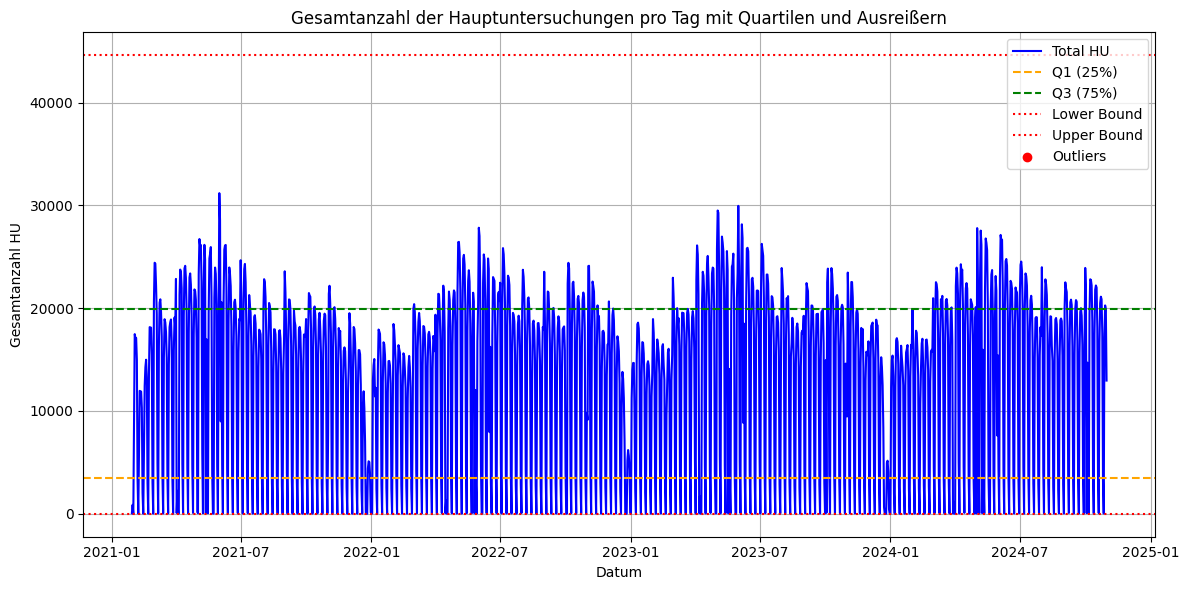

In [64]:
# Aggregation der Gesamtanzahl aller Unterbüros pro Tag
aggregated_df = df_all_days.group_by("DATUM").agg(
    total_HU=pl.col("HU").sum()
)

# Quartile und IQR berechnen
q1 = aggregated_df["total_HU"].quantile(0.25)
q3 = aggregated_df["total_HU"].quantile(0.75)
iqr = q3 - q1

# Grenzen für Ausreißer
lower_bound = max(0, q1 - 1.5 * iqr)
upper_bound = q3 + 1.5 * iqr

# Filtern von Ausreißern
outliers = aggregated_df.filter(
    (pl.col("total_HU") < lower_bound) | (pl.col("total_HU") > upper_bound)
)

# Visualisierung
plt.figure(figsize=(12, 6))

aggregated_df = aggregated_df.sort("DATUM")

# Zeitreihe der Gesamtzahl HU
plt.plot(aggregated_df["DATUM"], aggregated_df["total_HU"], label="Total HU", color="blue")

# Quartile und IQR-Grenzen
plt.axhline(y=q1, color='orange', linestyle='--', label="Q1 (25%)")
plt.axhline(y=q3, color='green', linestyle='--', label="Q3 (75%)")
plt.axhline(y=lower_bound, color='red', linestyle=':', label="Lower Bound")
plt.axhline(y=upper_bound, color='red', linestyle=':', label="Upper Bound")

# Ausreißer markieren
plt.scatter(outliers["DATUM"], outliers["total_HU"], color='red', label="Outliers", zorder=5)

# Diagramm beschriften
plt.xlabel("Datum")
plt.ylabel("Gesamtanzahl HU")
plt.title("Gesamtanzahl der Hauptuntersuchungen pro Tag mit Quartilen und Ausreißern")
plt.legend()
plt.grid(True)

# Diagramm anzeigen
plt.tight_layout()
plt.show()


Es gibt keinen Tag, an denen die summierten HUs einen Ausreißer bilden. Das war zu erwarten (Gesetz der großen Zahlen).

Ausreißer in den einzelnen Unterbüros:

In [65]:
# Daten gruppieren und Quartile/IQR für jedes Unterbüro berechnen
grouped_outliers = []

# Iteration über jedes Unterbüro
for buero, df in df_all_days.group_by("UNIQUE_UNTERBUERO_ANONYM"):
    # Quartile und IQR berechnen
    q1 = df["HU"].quantile(0.25)
    q3 = df["HU"].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Filtern von Ausreißern
    outliers = df.filter((df["HU"] < lower_bound) | (df["HU"] > upper_bound))
    grouped_outliers.append((buero, outliers))

# Ergebnisse in einem Dictionary speichern
outlier_dict = {buero: outliers for buero, outliers in grouped_outliers}

# Zusammenfassung der Anzahl von Ausreißern pro Unterbüro
summary = {buero: len(outliers) for buero, outliers in grouped_outliers}
print(summary)

{('UB_764',): 0, ('UB_447',): 3, ('UB_503',): 0, ('UB_1189',): 0, ('UB_712',): 0, ('UB_243',): 5, ('UB_991',): 0, ('UB_779',): 61, ('UB_137',): 0, ('UB_325',): 0, ('UB_686',): 0, ('UB_710',): 0, ('UB_1351',): 1, ('UB_817',): 0, ('UB_482',): 0, ('UB_758',): 0, ('UB_173',): 2, ('UB_919',): 0, ('UB_827',): 1, ('UB_1032',): 66, ('UB_704',): 37, ('UB_834',): 0, ('UB_45',): 0, ('UB_1015',): 3, ('UB_591',): 0, ('UB_781',): 8, ('UB_1205',): 78, ('UB_668',): 0, ('UB_442',): 56, ('UB_1122',): 133, ('UB_93',): 4, ('UB_1002',): 0, ('UB_561',): 0, ('UB_1387',): 23, ('UB_56',): 0, ('UB_541',): 0, ('UB_219',): 0, ('UB_618',): 4, ('UB_1184',): 5, ('UB_465',): 0, ('UB_1200',): 41, ('UB_97',): 0, ('UB_1113',): 0, ('UB_168',): 5, ('UB_1328',): 2, ('UB_531',): 0, ('UB_434',): 3, ('UB_50',): 0, ('UB_870',): 43, ('UB_849',): 1, ('UB_667',): 51, ('UB_253',): 0, ('UB_142',): 6, ('UB_76',): 0, ('UB_1228',): 318, ('UB_255',): 0, ('UB_600',): 36, ('UB_587',): 12, ('UB_1001',): 157, ('UB_529',): 1, ('UB_816',): 3

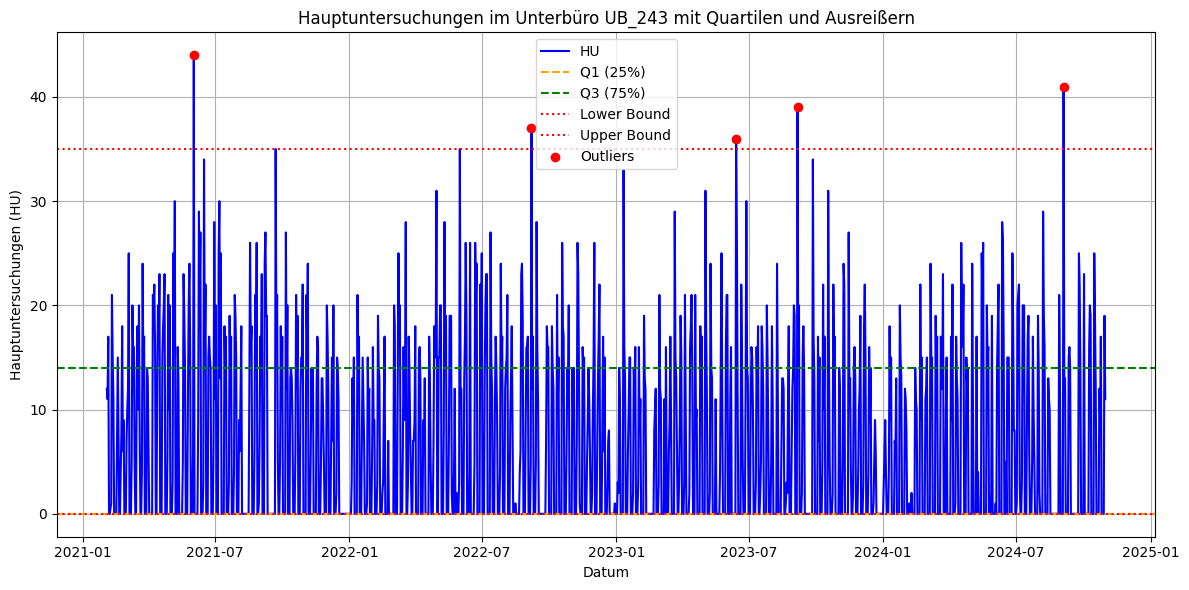

In [70]:
# Beispiel: Visualisierung eines spezifischen Unterbüros
specific_buero = "UB_243"  # Beispielname
df = df_all_days.filter(pl.col("UNIQUE_UNTERBUERO_ANONYM") == specific_buero).sort("DATUM")

# Quartile und IQR berechnen
q1 = df["HU"].quantile(0.25)
q3 = df["HU"].quantile(0.75)
iqr = q3 - q1

lower_bound = max(0, q1 - 1.5 * iqr)
upper_bound = q3 + 1.5 * iqr

# Ausreißer filtern
outliers = df.filter((df["HU"] < lower_bound) | (df["HU"] > upper_bound))

# Visualisierung
plt.figure(figsize=(12, 6))
plt.plot(df["DATUM"], df["HU"], label="HU", color="blue")
plt.axhline(y=q1, color='orange', linestyle='--', label="Q1 (25%)")
plt.axhline(y=q3, color='green', linestyle='--', label="Q3 (75%)")
plt.axhline(y=lower_bound, color='red', linestyle=':', label="Lower Bound")
plt.axhline(y=upper_bound, color='red', linestyle=':', label="Upper Bound")
plt.scatter(outliers["DATUM"], outliers["HU"], color='red', label="Outliers", zorder=5)

# Beschriftung
plt.xlabel("Datum")
plt.ylabel("Hauptuntersuchungen (HU)")
plt.title(f"Hauptuntersuchungen im Unterbüro {specific_buero} mit Quartilen und Ausreißern")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Dieses beispelhafte Unterbüro hat ein paar Ausreißer. Ich habe geschaut, ob es an diesen Tagen besondere Ereignisse gab, die dazu führen könnten. Gab es nicht. Daher behalte ich die Ausreißer in den Trainingsdaten.

Summierte Anzhal an Ausreißern über alle Unterbüros:

C:\Users\Krupinski\AppData\Local\Temp\ipykernel_18244\1941579623.py:16: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



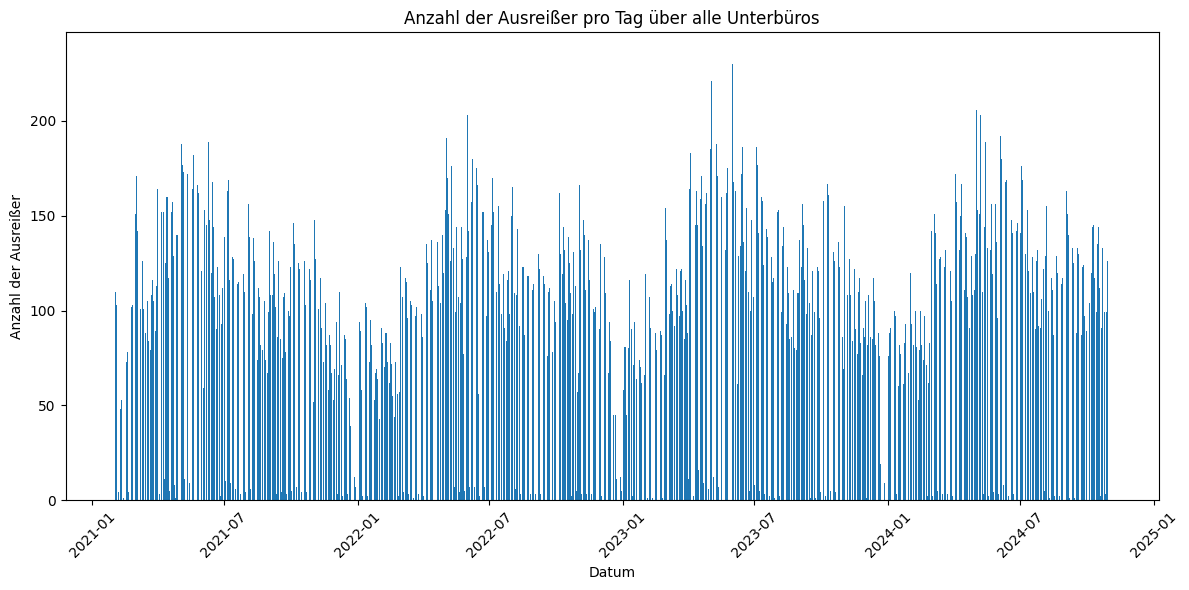

In [72]:
# Schritt 1: Berechne den Interquartilsabstand (IQR) der HU-Werte für jedes Unterbüro
q1 = df_all_days.select(pl.col("HU").quantile(0.25)).to_numpy()[0][0]
q3 = df_all_days.select(pl.col("HU").quantile(0.75)).to_numpy()[0][0]
iqr = q3 - q1

# Schritt 2: Bestimme die Ausreißer (Werte, die außerhalb des Interquartilsabstands liegen)
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Markiere die Ausreißer (Werte, die unterhalb oder oberhalb der Grenzen liegen)
df_all_days = df_all_days.with_columns(
    ((pl.col("HU") < lower_bound) | (pl.col("HU") > upper_bound)).alias("is_outlier")
)

# Schritt 3: Zähle die Ausreißer pro Tag
outliers_by_day = df_all_days.filter(pl.col("is_outlier")).group_by("DATUM").agg(pl.count().alias("outlier_count"))

# Schritt 4: Visualisiere die Tage mit den meisten Ausreißern
outliers_by_day = outliers_by_day.sort("DATUM")

# Visualisierung
plt.figure(figsize=(12, 6))
plt.bar(outliers_by_day["DATUM"].to_list(), outliers_by_day["outlier_count"].to_list())
plt.xlabel('Datum')
plt.ylabel('Anzahl der Ausreißer')
plt.title('Anzahl der Ausreißer pro Tag über alle Unterbüros')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Die Anzahl der Ausreißer spiegelt den seasonalen Verlauf der HUs wieder. Das macht Sinn, weil es an Tagen mit vielen HUs auch mehr Ausreißer gibt.

Alle Ausreißer sind also natürlichem Ursprungs und werden daher nicht entfernt.

### Relationships

Im folgenden schauen wir uns an, wie die einzelnen Variabeln mit der Zielvariabel korrelieren:

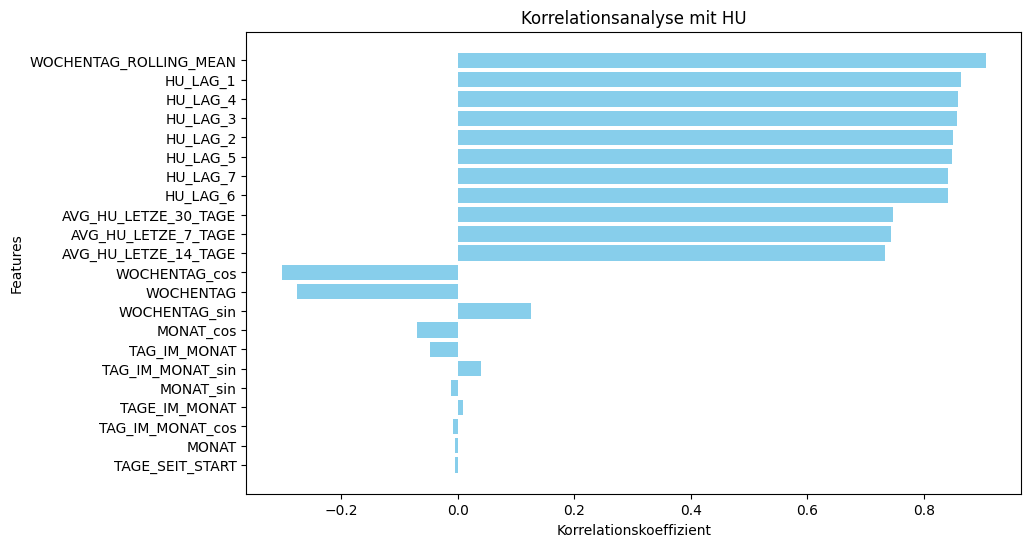

In [77]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

# Schritt 1: Numerische Features extrahieren
numerical_columns = [
    col for col in df_all_days.columns
    if isinstance(df_all_days[col].dtype, (pl.Int64, pl.Float64, pl.Int8, pl.Float32))  # Überprüfung des Datentyps der Spalten
]
numerical_df = df_all_days.select(numerical_columns)

# Schritt 2: Korrelationsmatrix berechnen
correlation_results = {
    col: numerical_df.select(pl.corr("HU", col)).to_numpy()[0][0]
    for col in numerical_columns if col != "HU"
}

# Schritt 3: Sortieren nach Stärke der Korrelation
sorted_correlations = sorted(correlation_results.items(), key=lambda x: abs(x[1]), reverse=True)

# Schritt 4: Visualisierung
features, correlations = zip(*sorted_correlations)
plt.figure(figsize=(10, 6))
plt.barh(features, correlations, color='skyblue')
plt.xlabel('Korrelationskoeffizient')
plt.ylabel('Features')
plt.title('Korrelationsanalyse mit HU')
plt.gca().invert_yaxis()
plt.show()


Wir sehen, dass der WOCHENTAG_ROLLING_MEAN am stärksten korreliert.

Aber Achtung:
1. Hierbei handlet es sich um lineare Korrelation. Nicht-lineare Korrelation wird hier nicht gemessen!
2. Eine negative Korrelation ist nicht schlechter als eine positive Korrelation. Der Betrag des Wertes gibt uns Auskunft über die Korrelationsstärke. Werte nahe 0 geben eine schwache Korrelation an, Werte nache 1 und -1 geben eine stakre Korrelation an.

Schauen wir uns die Korrelation zwischen allen Variabeln an. Dafür eignet sich eine Korrelationsmatrix:

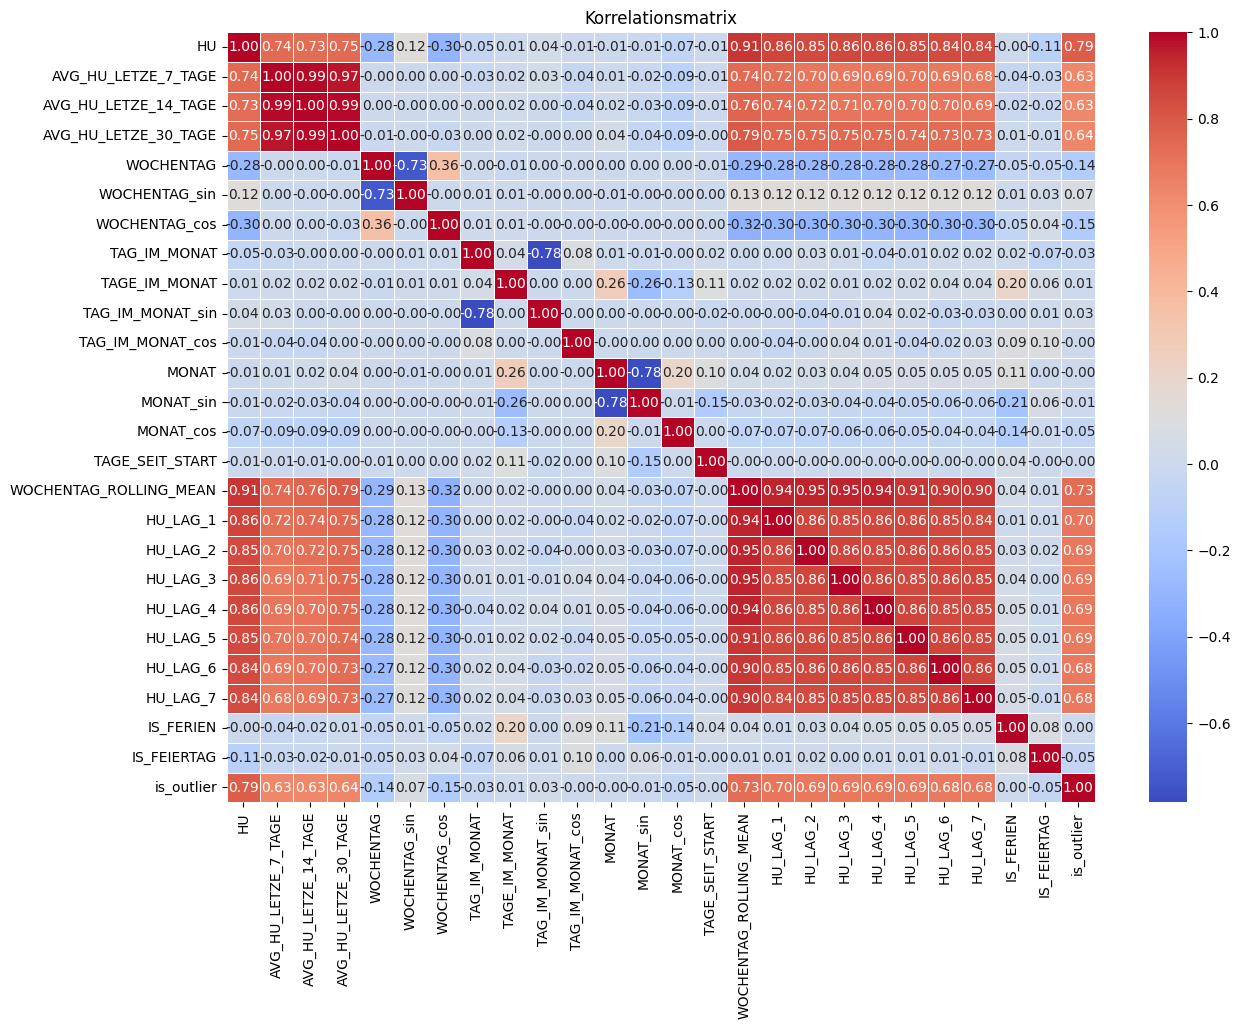

In [78]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Angenommen, df_all_days ist ein Polars DataFrame
# Sample 100 Zeilen und droppe die nicht relevanten Spalten
df_sampled = df_all_days.select(
    pl.exclude(["DATUM", "BUNDESLAND", "UNIQUE_UNTERBUERO_ANONYM"])
)

# Konvertiere den Polars DataFrame in einen Pandas DataFrame
df_pandas = df_sampled.to_pandas()

# Berechne die Korrelationsmatrix
corr_matrix = df_pandas.corr()

# Visualisierung der Korrelationsmatrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Korrelationsmatrix")
plt.show()


Hier sehen wir, dass zum Beispiel WOCHENTAG_ROLLING_MEAN sehr stark mit den LAG_Featrues korreliert. Diese Multikolinearität kann zu Overfitting und einer schlechteren Vorhersage bei bestimmten Modelltypen führen. Bei meinem geplanten Modelltyp (LightGBM) ist das aber kein Problem.

## Model

### Select model

### Training and validation

### Fit model

### Evaluation on test set

### Save model



Save your model in the folder `models/`. Use a meaningful name and a timestamp.

## Conclusions